</font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Exploratory Data Analysis](#[Exploratory_Data_Analysis])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font> <font size="2">[Modeling](#[Modeling])</font> <font size="2">[Results](#[Results])</font>

In [1]:
filename_version='2dot7'

In [2]:
import sys
sys.path.append("/Users/pauljacob/Library/Python/3.8/lib/python/site-packages")

In [3]:
!pip3 install ipython-autotime --quiet


In [4]:
%load_ext autotime

time: 202 µs (started: 2022-10-15 12:04:12 -07:00)


In [5]:
!pip3 install cookiecutter

Defaulting to user installation because normal site-packages is not writeable
time: 1.26 s (started: 2022-10-15 12:04:12 -07:00)


## Import Libraries

In [6]:
#get libraries
import pandas as pd
import os
import numpy as np
#from functools import reduce


#get visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

class color:
   BOLD = '\033[1m'
   END = '\033[0m'

    
#get ML functions
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV, StratifiedKFold, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn import __version__ as sklearn_version
import datetime
from sklearn import metrics
#from sklearn.pipeline import make_pipeline


#get icr module and associated common functions
import in_vehicle_coupon_recommendation as icr
from in_vehicle_coupon_recommendation import p, rcp, rpp, rcr, sr, pl, pdc, save_and_return_data_frame, initialize_custom_notebook_settings

time: 1.39 s (started: 2022-10-15 12:04:13 -07:00)


In [7]:
#initialize notebook
initialize_custom_notebook_settings()

time: 1.94 ms (started: 2022-10-15 12:04:15 -07:00)


## Get In-Vehicle Coupon Recommendation Dataset

In [8]:
df = pd.read_csv(os.path.join('..', 'data', 'raw', 'in-vehicle-coupon-recommendation.csv'))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  car                   108 non-null    object
 15  Bar                   12577 non-null

<font size="5"><a id='[Data_Wrangling]'></a></font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Exploratory Data Analysis](#[Exploratory_Data_Analysis])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font> <font size="2">[Modeling](#[Modeling])</font> <font size="2">[Results](#[Results])</font>

<font size="6"><a id='[Data_Wrangling]'>**Data Wrangling**</a> </font>

In [9]:
#rename 'passanger' and 'coupon' column
df = df.rename(columns={'passanger':'passenger', 'coupon':'coupon_venue_type'})



#decode string 'age' values to (explicit) string age ranges
column_name_age_value_list = list(df.loc[:, 'age'].unique())
column_name_age_value_list_cleaned_up = ['21-25', '46-49', '26-30', '31-35', '41-45', '50+', '36-40', '<21']
column_name_age_value_dict = dict(zip(column_name_age_value_list, column_name_age_value_list_cleaned_up))
df.loc[:, 'age'] = df.loc[:, 'age'].replace(column_name_age_value_dict)



#drop column 'toCoupon_GEQ5min' because all 1's
column_name_list_not_toCoupon_GEQ5min = [column_name for column_name in df.columns if column_name != 'toCoupon_GEQ5min']
df = df.loc[:, column_name_list_not_toCoupon_GEQ5min]



#rename values in columns 'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', and 'Restaurant20To50' to math language...
#get column name list for column values uniques that are the same as column name 'CarryAway' value uniques
column_name_list_same_unique_values = []
for column_name in df.columns:    
    value = icr.column_name_value_sets_equal(df, column_name1='CarryAway', column_name2=column_name)
    if value == 1:
        column_name_list_same_unique_values = column_name_list_same_unique_values + [column_name]
#rename values in columns 'Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', and 'Restaurant20To50' to math language
column_name_Bar_value_list = list(df.loc[:, 'Bar'].unique())
column_name_Bar_value_list_cleaned_up = ['never', '<1', '1-3', '>8', np.nan, '4-8']
column_name_Bar_value_dict = dict(zip(column_name_Bar_value_list, column_name_Bar_value_list_cleaned_up))
df.loc[:, column_name_list_same_unique_values] = df.loc[:, column_name_list_same_unique_values].replace(column_name_Bar_value_dict)



#clean up columns 'direction_same' and 'direction_opp' to 'direction_same_or_opposite'
#drop column 'direction_same'
column_name_list_not_direction_same = [column_name for column_name in df.columns if column_name != 'direction_same']
df = df.loc[:, column_name_list_not_direction_same]
#rename 'direction_opp' to 'direction_same_or_opposite'
df = df.rename(columns={'direction_opp':'direction_same_or_opposite'})



#dealing with missing values:
    #solution1: fill in missing values with 'no response' or 'unknown'
    #solution2: fillna with mode of column
    #solution3: use other features to predict what NaN values of occurences per month variables
    #solution4: drop the rows that have null values

#solution1: fill in missing values with 'no response' or 'unknown'
column_name_list = ['Bar', 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50', 'car']
df.loc[:, column_name_list] = df.loc[:, column_name_list].fillna('no response')
p(df)

(12684, 24)


,destination,passenger,weather,temperature,time,coupon_venue_type,expiration,gender,age,maritalStatus,has_children,education,occupation,income,car,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same_or_opposite,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21-25,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,no response,never,never,no response,4-8,1-3,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21-25,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,no response,never,never,no response,4-8,1-3,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21-25,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,no response,never,never,no response,4-8,1-3,1,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21-25,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,no response,never,never,no response,4-8,1-3,1,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21-25,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,no response,never,never,no response,4-8,1-3,1,0,1,0
12679,Home,Partner,Rainy,55,6PM,Carry out & Take away,1d,Male,26-30,Single,0,Bachelors degree,Sales & Related,$75000 - $87499,no response,never,never,1-3,4-8,1-3,0,0,0,1
12680,Work,Alone,Rainy,55,7AM,Carry out & Take away,1d,Male,26-30,Single,0,Bachelors degree,Sales & Related,$75000 - $87499,no response,never,never,1-3,4-8,1-3,0,0,1,1
12681,Work,Alone,Snowy,30,7AM,Coffee House,1d,Male,26-30,Single,0,Bachelors degree,Sales & Related,$75000 - $87499,no response,never,never,1-3,4-8,1-3,0,0,0,0
12682,Work,Alone,Snowy,30,7AM,Bar,1d,Male,26-30,Single,0,Bachelors degree,Sales & Related,$75000 - $87499,no response,never,never,1-3,4-8,1-3,1,1,1,0
12683,Work,Alone,Sunny,80,7AM,Restaurant(20-50),2h,Male,26-30,Single,0,Bachelors degree,Sales & Related,$75000 - $87499,no response,never,never,1-3,4-8,1-3,0,0,0,0


time: 81.4 ms (started: 2022-10-15 12:04:15 -07:00)


<font size="5"><a id='[Feature_Engineering]'></a></font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Exploratory Data Analysis](#[Exploratory_Data_Analysis])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font> <font size="2">[Modeling](#[Modeling])</font> <font size="2">[Results](#[Results])</font>

<font size="6"><a id='[Feature_Engineering]'>**Feature Engineering**</a> </font>

## Get Category Representative Numeric Encoding for Features: expiration, time, age, income

In [10]:
#category representative numeric encoding: expiration, time, age, income

expiration_category_representative_numeric_encoding={'expiration':{'2h':2, '1d':24}}
time_category_representative_numeric_encoding={'time':{'7AM':7,'10AM':10, '2PM':14, '6PM':18, '10PM':22}}
age_category_representative_numeric_encoding={'age':{'<21':18, '21-25':23, '26-30':28, '31-35':33, '36-40':38, '41-45':43, '46-49':48, '50+':56}}
income_category_representative_numeric_encoding={'income':{'Less than $12500':6250, '$12500 - $24999':18749.5, '$25000 - $37499':31249.5, '$37500 - $49999':43749.5, '$50000 - $62499':56249.5, '$62500 - $74999':68749.5, '$75000 - $87499':81249.5, '$87500 - $99999':93749.5,'$100000 or More':150000}}

#combine category representative numeric encoding dictionaries
category_representative_numeric_encoding_dictionary = expiration_category_representative_numeric_encoding|time_category_representative_numeric_encoding|age_category_representative_numeric_encoding|income_category_representative_numeric_encoding

category_representative_numeric_encoding_key_list = list(category_representative_numeric_encoding_dictionary.keys())

df_category_representative_numeric_encoding = df.loc[:, category_representative_numeric_encoding_key_list].replace(category_representative_numeric_encoding_dictionary)

#rename columns
category_representative_numeric_encoding_substring='_category_representative_numeric_encoding'

column_name_list_category_representative_numeric_encoding = [str(column_name) + category_representative_numeric_encoding_substring for column_name in category_representative_numeric_encoding_key_list]

column_name_dictionary_category_representative_numeric_encoding = dict(zip(category_representative_numeric_encoding_key_list, column_name_list_category_representative_numeric_encoding))

df_category_representative_numeric_encoding = df_category_representative_numeric_encoding.rename(columns=column_name_dictionary_category_representative_numeric_encoding)

p(df_category_representative_numeric_encoding)

(12684, 4)


,expiration_category_representative_numeric_encoding,time_category_representative_numeric_encoding,age_category_representative_numeric_encoding,income_category_representative_numeric_encoding
0,24,14,23,43749.5
1,2,10,23,43749.5
2,2,10,23,43749.5
3,2,14,23,43749.5
4,24,14,23,43749.5
12679,24,18,28,81249.5
12680,24,7,28,81249.5
12681,24,7,28,81249.5
12682,24,7,28,81249.5
12683,2,7,28,81249.5


time: 29.4 ms (started: 2022-10-15 12:04:15 -07:00)


## Get Binary Encoding for Features: gender, expiration

In [11]:
#binary encoding: gender, expiration
gender_binary_encoding={'gender':{'Female':0, 'Male':1}}
expiration_binary_encoding={'expiration':{'2h':0, '1d':1}}

binary_encoding_dictionary = gender_binary_encoding|expiration_binary_encoding

binary_encoding_key_list = list(binary_encoding_dictionary.keys())

df_binary_encoding = df.loc[:, binary_encoding_key_list].replace(binary_encoding_dictionary)


#rename columns
binary_encoding_substring = '_binary_encoding'
column_name_list_binary_encoding = [str(column_name) + binary_encoding_substring for column_name in binary_encoding_key_list]
column_name_dictionary_binary_encoding = dict(zip(binary_encoding_key_list, column_name_list_binary_encoding))
df_binary_encoding = df_binary_encoding.rename(columns=column_name_dictionary_binary_encoding)

p(df_binary_encoding)

(12684, 2)


,gender_binary_encoding,expiration_binary_encoding
0,0,1
1,0,0
2,0,0
3,0,0
4,0,1
12679,1,1
12680,1,1
12681,1,1
12682,1,1
12683,1,0


time: 13.2 ms (started: 2022-10-15 12:04:15 -07:00)


## Get Ordinal Integer Encoding for Features: coupon_venue_type, education, income, age, time, temperature

In [12]:
#ordinal integer encoding: coupon_venue_type, education, income, age, time, temperature

#category ordinal features to ordinal integer encoding
coupon_venue_type_ordinal_integer_encoding={'coupon_venue_type':{'Coffee House':1, 'Bar':2, 'Carry out & Take away':3, 'Restaurant(<20)':4, 'Restaurant(20-50)':5}}
education_ordinal_integer_encoding={'education':{'Some High School':1, 'High School Graduate':2, 'Some college - no degree':3, 'Associates degree':4, 'Bachelors degree':5,'Graduate degree (Masters or Doctorate)':6}}
income_ordinal_integer_encoding={'income':{'Less than $12500':1, '$12500 - $24999':2, '$25000 - $37499':3, '$37500 - $49999':4, '$50000 - $62499':5, '$62500 - $74999':6, '$75000 - $87499':7, '$87500 - $99999':8, '$100000 or More':9}}
age_ordinal_integer_encoding={'age':{'<21':1, '21-25':2, '26-30':3, '31-35':4, '36-40':5, '41-45':6, '46-49':7, '50+':8}}
time_ordinal_integer_encoding={'time':{'7AM':1, '10AM':2, '2PM':3, '6PM':4, '10PM':5}}

#numeric to ordinal integer encoding
temperature_ordinal_integer_encoding={'temperature':{30:1, 55:2, 80:3}}


ordinal_integer_encoding_dictionary = coupon_venue_type_ordinal_integer_encoding|education_ordinal_integer_encoding|income_ordinal_integer_encoding|age_ordinal_integer_encoding|time_ordinal_integer_encoding|temperature_ordinal_integer_encoding

ordinal_integer_encoding_key_list = list(ordinal_integer_encoding_dictionary.keys())

df_ordinal_integer_encoding = df.loc[:, ordinal_integer_encoding_key_list].replace(ordinal_integer_encoding_dictionary)

#rename columns
ordinal_integer_encoding_substring='_ordinal_integer_encoding'
column_name_list_ordinal_integer_encoding=[str(column_name) + ordinal_integer_encoding_substring for column_name in ordinal_integer_encoding_key_list]
column_name_dictionary_ordinal_integer_encoding=dict(zip(ordinal_integer_encoding_key_list,column_name_list_ordinal_integer_encoding))
df_ordinal_integer_encoding=df_ordinal_integer_encoding.rename(columns=column_name_dictionary_ordinal_integer_encoding)

p(df_ordinal_integer_encoding)

(12684, 6)


,coupon_venue_type_ordinal_integer_encoding,education_ordinal_integer_encoding,income_ordinal_integer_encoding,age_ordinal_integer_encoding,time_ordinal_integer_encoding,temperature_ordinal_integer_encoding
0,4,3,4,2,3,2
1,1,3,4,2,2,3
2,3,3,4,2,2,3
3,1,3,4,2,3,3
4,1,3,4,2,3,3
12679,3,5,7,3,4,2
12680,3,5,7,3,1,2
12681,1,5,7,3,1,1
12682,2,5,7,3,1,1
12683,5,5,7,3,1,3


time: 37 ms (started: 2022-10-15 12:04:15 -07:00)


## Get Venue Type Visits Per Month Yes Response to Ordinal Integer Encoding for Features: bar, coffeehouse, carryaway, restaurantlessthan20, restaurant20to50

In [13]:
#venue type visits per month yes response to ordinal integer encoding: bar, coffeehouse, carryaway, restaurantlessthan20, restaurant20to50
bar_yes_response_ordinal_integer_encoding={'Bar':{'never':1, '<1':2, '1-3':3, '4-8':4, '>8':5, 'no response':0}}
coffeehouse_yes_response_ordinal_integer_encoding={'CoffeeHouse':{'never':1, '<1':2, '1-3':3, '4-8':4, '>8':5, 'no response':0}}
carryaway_yes_response_ordinal_integer_encoding={'CarryAway':{'never':1, '<1':2, '1-3':3, '4-8':4, '>8':5, 'no response':0}}
restaurantlessthan20_yes_response_ordinal_integer_encoding={'RestaurantLessThan20':{'never':1, '<1':2, '1-3':3, '4-8':4, '>8':5, 'no response':0}}
restaurant20to50_yes_response_ordinal_integer_encoding={'Restaurant20To50':{'never':1, '<1':2, '1-3':3, '4-8':4, '>8':5, 'no response':0}}


yes_response_ordinal_integer_encoding_dictionary=bar_yes_response_ordinal_integer_encoding|coffeehouse_yes_response_ordinal_integer_encoding|carryaway_yes_response_ordinal_integer_encoding|restaurantlessthan20_yes_response_ordinal_integer_encoding|restaurant20to50_yes_response_ordinal_integer_encoding

yes_response_ordinal_integer_encoding_key_list=list(yes_response_ordinal_integer_encoding_dictionary.keys())

df_yes_response_ordinal_integer_encoding = df.loc[:, yes_response_ordinal_integer_encoding_key_list].replace(yes_response_ordinal_integer_encoding_dictionary)

#rename columns
yes_response_ordinal_integer_encoding_substring='_yes_response_ordinal_integer_encoding'
column_name_list_yes_response_ordinal_integer_encoding=[str(column_name) + yes_response_ordinal_integer_encoding_substring for column_name in yes_response_ordinal_integer_encoding_key_list]
column_name_dictionary_yes_response_ordinal_integer_encoding=dict(zip(yes_response_ordinal_integer_encoding_key_list, column_name_list_yes_response_ordinal_integer_encoding))
df_yes_response_ordinal_integer_encoding = df_yes_response_ordinal_integer_encoding.rename(columns=column_name_dictionary_yes_response_ordinal_integer_encoding)

p(df_yes_response_ordinal_integer_encoding)

(12684, 5)


,Bar_yes_response_ordinal_integer_encoding,CoffeeHouse_yes_response_ordinal_integer_encoding,CarryAway_yes_response_ordinal_integer_encoding,RestaurantLessThan20_yes_response_ordinal_integer_encoding,Restaurant20To50_yes_response_ordinal_integer_encoding
0,1,1,0,4,3
1,1,1,0,4,3
2,1,1,0,4,3
3,1,1,0,4,3
4,1,1,0,4,3
12679,1,1,3,4,3
12680,1,1,3,4,3
12681,1,1,3,4,3
12682,1,1,3,4,3
12683,1,1,3,4,3


time: 35.3 ms (started: 2022-10-15 12:04:15 -07:00)


## Get Venue Type Visits Per Month No Response to Indicator Variable for Features: bar, coffeehouse, carryaway, restaurantlessthan20, restaurant20to50

In [14]:
#venue type visits per month no response to indicator variable: bar, coffeehouse, carryaway, restaurantlessthan20, restaurant20to50
bar_no_response_indicator_variable={'Bar':{'never':0, '<1':0, '1-3':0, '4-8':0, '>8':0, 'no response':1}}
coffeehouse_no_response_indicator_variable={'CoffeeHouse':{'never':0, '<1':0, '1-3':0, '4-8':0, '>8':0, 'no response':1}}
carryaway_no_response_indicator_variable={'CarryAway':{'never':0, '<1':0, '1-3':0, '4-8':0, '>8':0, 'no response':1}}
restaurantlessthan20_no_response_indicator_variable={'RestaurantLessThan20':{'never':0, '<1':0, '1-3':0, '4-8':0, '>8':0, 'no response':1}}
restaurant20to50_no_response_indicator_variable={'Restaurant20To50':{'never':0, '<1':0, '1-3':0, '4-8':0, '>8':0, 'no response':1}}

no_response_indicator_variable_dictionary=bar_no_response_indicator_variable|coffeehouse_no_response_indicator_variable|carryaway_no_response_indicator_variable|restaurantlessthan20_no_response_indicator_variable|restaurant20to50_no_response_indicator_variable

no_response_indicator_variable_key_list=list(no_response_indicator_variable_dictionary.keys())

df_no_response_indicator_variable=df.loc[:, no_response_indicator_variable_key_list].replace(no_response_indicator_variable_dictionary)

#rename columns
no_response_indicator_variable='_no_response_indicator'
column_name_list_no_response_indicator_variable=[str(column_name) + no_response_indicator_variable for column_name in no_response_indicator_variable_key_list]
column_name_dictionary_no_response_indicator_variable=dict(zip(no_response_indicator_variable_key_list, column_name_list_no_response_indicator_variable))
df_no_response_indicator_variable=df_no_response_indicator_variable.rename(columns=column_name_dictionary_no_response_indicator_variable)

p(df_no_response_indicator_variable)

(12684, 5)


,Bar_no_response_indicator,CoffeeHouse_no_response_indicator,CarryAway_no_response_indicator,RestaurantLessThan20_no_response_indicator,Restaurant20To50_no_response_indicator
0,0,0,1,0,0
1,0,0,1,0,0
2,0,0,1,0,0
3,0,0,1,0,0
4,0,0,1,0,0
12679,0,0,0,0,0
12680,0,0,0,0,0
12681,0,0,0,0,0
12682,0,0,0,0,0
12683,0,0,0,0,0


time: 35.4 ms (started: 2022-10-15 12:04:15 -07:00)


## Concatenate the Data Frames

In [15]:
#concatenate the data frames

#get data frame list
data_frame_list=[df, df_category_representative_numeric_encoding, df_binary_encoding, df_ordinal_integer_encoding, df_yes_response_ordinal_integer_encoding, df_no_response_indicator_variable]

#concat data frames
df = pd.concat(data_frame_list, axis=1)

p(df)

(12684, 46)


,destination,passenger,weather,temperature,time,coupon_venue_type,expiration,gender,age,maritalStatus,has_children,education,occupation,income,car,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same_or_opposite,Y,expiration_category_representative_numeric_encoding,time_category_representative_numeric_encoding,age_category_representative_numeric_encoding,income_category_representative_numeric_encoding,gender_binary_encoding,expiration_binary_encoding,coupon_venue_type_ordinal_integer_encoding,education_ordinal_integer_encoding,income_ordinal_integer_encoding,age_ordinal_integer_encoding,time_ordinal_integer_encoding,temperature_ordinal_integer_encoding,Bar_yes_response_ordinal_integer_encoding,CoffeeHouse_yes_response_ordinal_integer_encoding,CarryAway_yes_response_ordinal_integer_encoding,RestaurantLessThan20_yes_response_ordinal_integer_encoding,Restaurant20To50_yes_response_ordinal_integer_encoding,Bar_no_response_indicator,CoffeeHouse_no_response_indicator,CarryAway_no_response_indicator,RestaurantLessThan20_no_response_indicator,Restaurant20To50_no_response_indicator
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21-25,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,no response,never,never,no response,4-8,1-3,0,0,1,1,24,14,23,43749.5,0,1,4,3,4,2,3,2,1,1,0,4,3,0,0,1,0,0
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21-25,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,no response,never,never,no response,4-8,1-3,0,0,1,0,2,10,23,43749.5,0,0,1,3,4,2,2,3,1,1,0,4,3,0,0,1,0,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21-25,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,no response,never,never,no response,4-8,1-3,1,0,1,1,2,10,23,43749.5,0,0,3,3,4,2,2,3,1,1,0,4,3,0,0,1,0,0
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21-25,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,no response,never,never,no response,4-8,1-3,1,0,1,0,2,14,23,43749.5,0,0,1,3,4,2,3,3,1,1,0,4,3,0,0,1,0,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21-25,Unmarried partner,1,Some college - no degree,Unemployed,$37500 - $49999,no response,never,never,no response,4-8,1-3,1,0,1,0,24,14,23,43749.5,0,1,1,3,4,2,3,3,1,1,0,4,3,0,0,1,0,0
12679,Home,Partner,Rainy,55,6PM,Carry out & Take away,1d,Male,26-30,Single,0,Bachelors degree,Sales & Related,$75000 - $87499,no response,never,never,1-3,4-8,1-3,0,0,0,1,24,18,28,81249.5,1,1,3,5,7,3,4,2,1,1,3,4,3,0,0,0,0,0
12680,Work,Alone,Rainy,55,7AM,Carry out & Take away,1d,Male,26-30,Single,0,Bachelors degree,Sales & Related,$75000 - $87499,no response,never,never,1-3,4-8,1-3,0,0,1,1,24,7,28,81249.5,1,1,3,5,7,3,1,2,1,1,3,4,3,0,0,0,0,0
12681,Work,Alone,Snowy,30,7AM,Coffee House,1d,Male,26-30,Single,0,Bachelors degree,Sales & Related,$75000 - $87499,no response,never,never,1-3,4-8,1-3,0,0,0,0,24,7,28,81249.5,1,1,1,5,7,3,1,1,1,1,3,4,3,0,0,0,0,0
12682,Work,Alone,Snowy,30,7AM,Bar,1d,Male,26-30,Single,0,Bachelors degree,Sales & Related,$75000 - $87499,no response,never,never,1-3,4-8,1-3,1,1,1,0,24,7,28,81249.5,1,1,2,5,7,3,1,1,1,1,3,4,3,0,0,0,0,0
12683,Work,Alone,Sunny,80,7AM,Restaurant(20-50),2h,Male,26-30,Single,0,Bachelors degree,Sales & Related,$75000 - $87499,no response,never,never,1-3,4-8,1-3,0,0,0,0,2,7,28,81249.5,1,0,5,5,7,3,1,3,1,1,3,4,3,0,0,0,0,0


time: 18.8 ms (started: 2022-10-15 12:04:15 -07:00)


<font size="5"><a id='[Exploratory_Data_Analysis]'></a></font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Exploratory Data Analysis](#[Exploratory_Data_Analysis])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font> <font size="2">[Modeling](#[Modeling])</font> <font size="2">[Results](#[Results])</font>

<font size="6"><a id='[Exploratory_Data_Analysis]'>**Exploratory Data Analysis**</a> </font>

In [16]:
#five types of coupons:
#bars
#takeaway food restaurants
#coffee houses
#cheap restaurants (average expense below $20 per person)
#expensive restaurants (average expense between $20 to $50 per person)

df.loc[:, 'coupon_venue_type'].value_counts()


Coffee House             3996
Restaurant(<20)          2786
Carry out & Take away    2393
Bar                      2017
Restaurant(20-50)        1492
Name: coupon_venue_type, dtype: int64

time: 3.75 ms (started: 2022-10-15 12:04:15 -07:00)


/var/folders/77/y4hv4_s9751293nzv4yrfrtm0000gn/T/ipykernel_83031/3831391204.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))


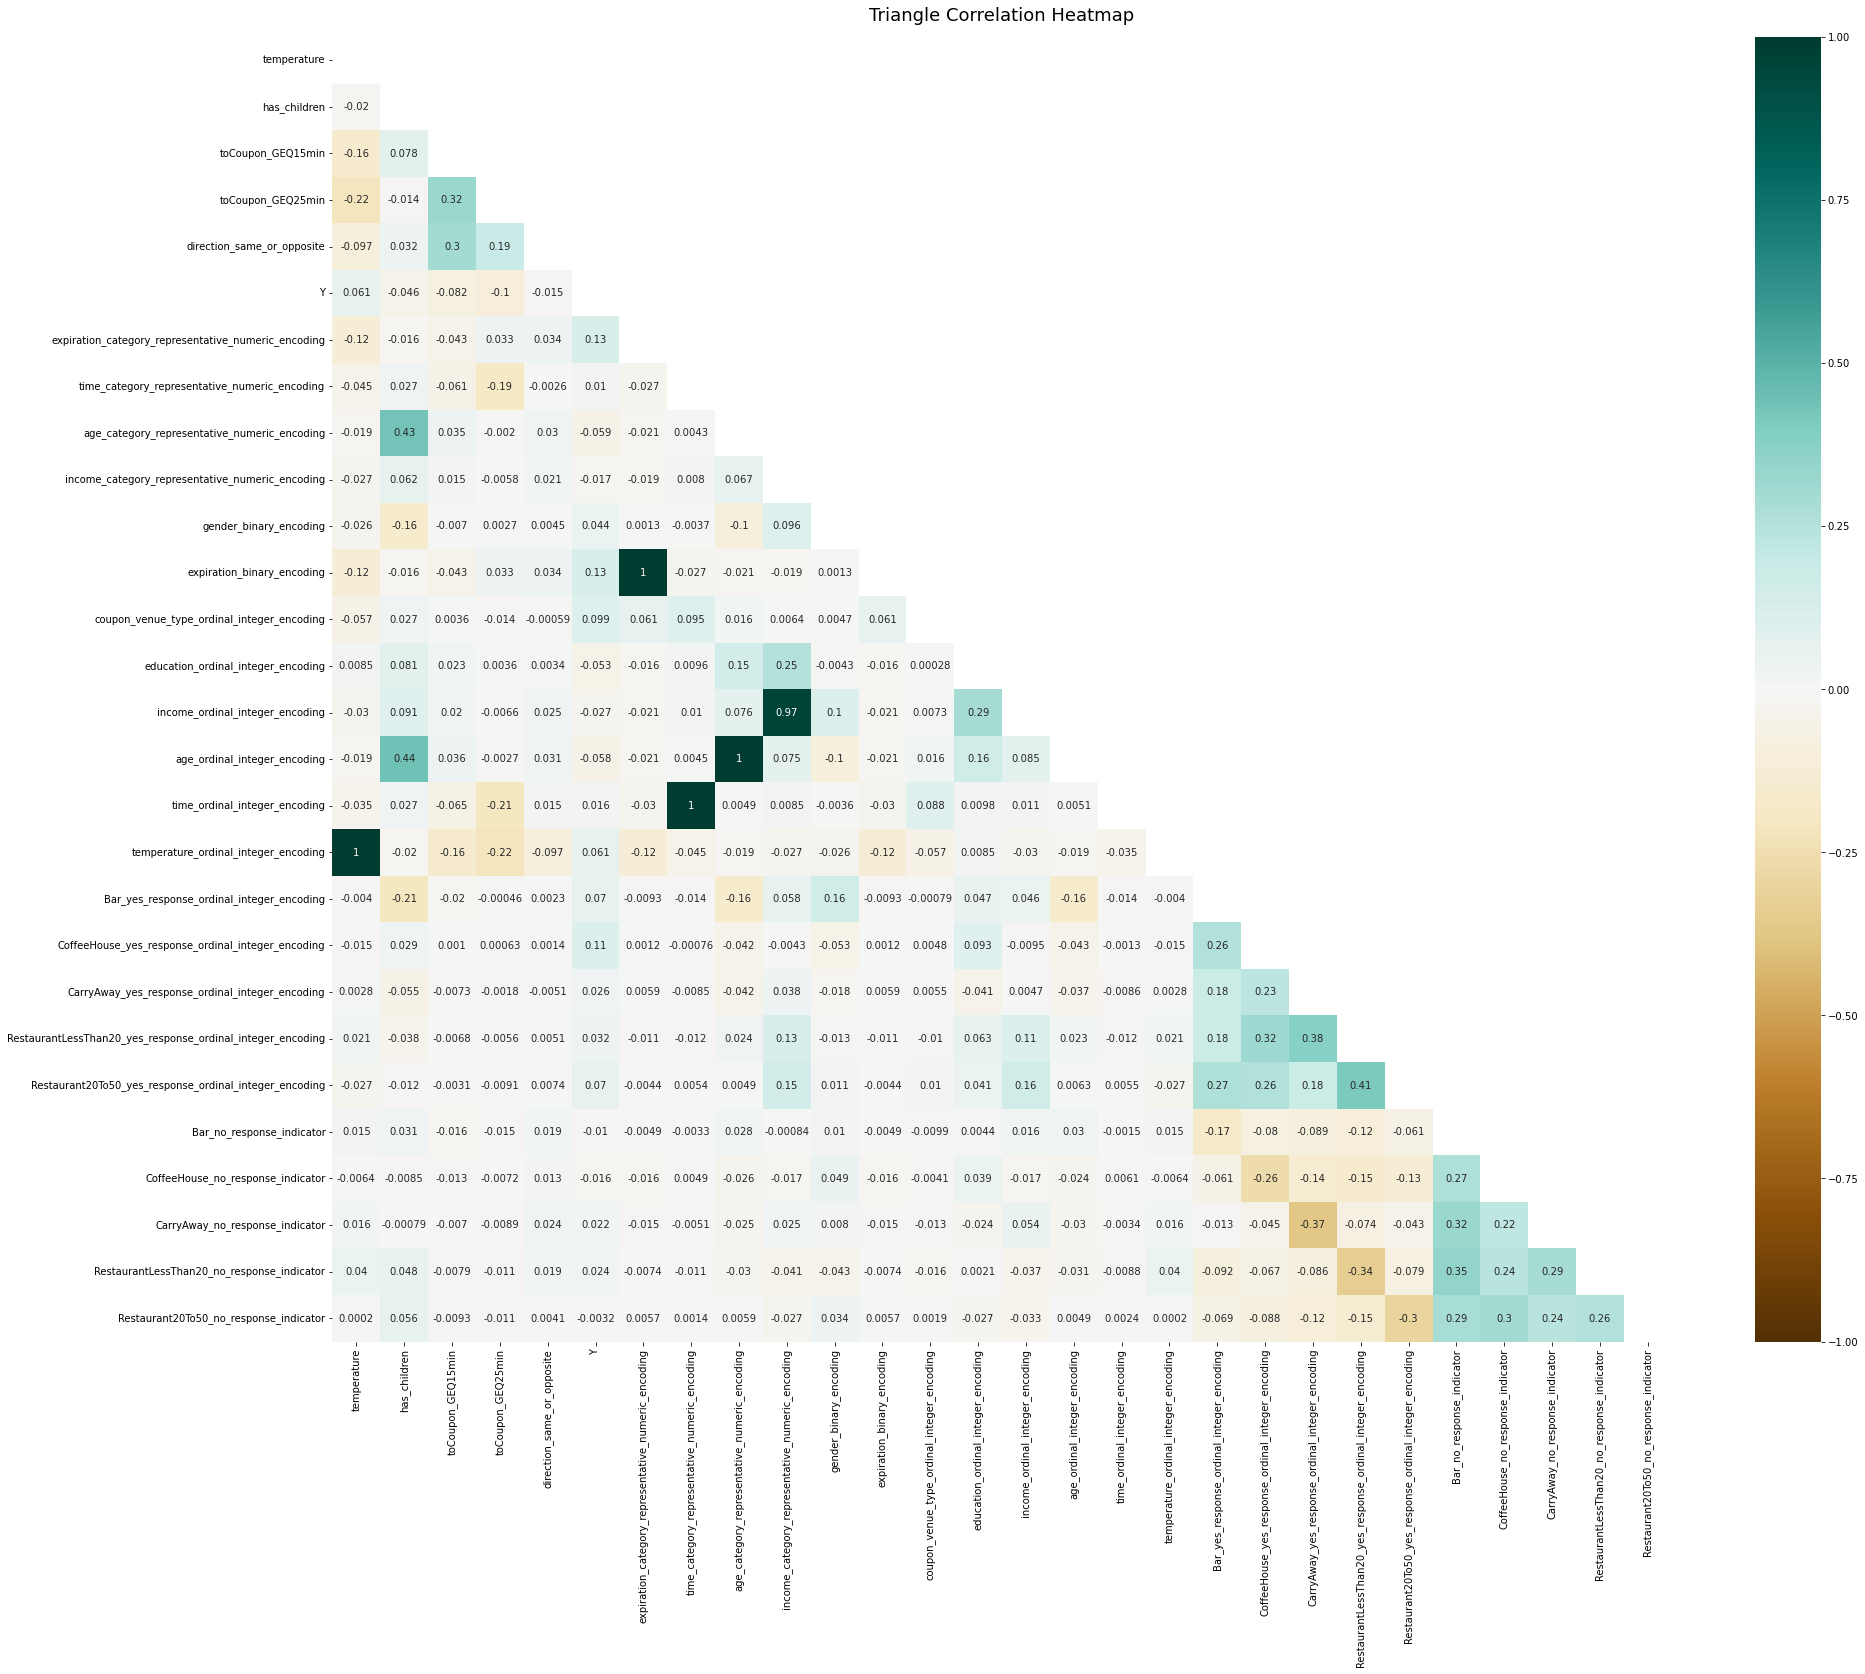

time: 10.5 s (started: 2022-10-15 12:04:15 -07:00)


In [17]:
#correlation heatmap

plt.figure(figsize=(30, 24))
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

plt.savefig('../reports/figures/figure_triangle_correlation_heatmap_random_forest_classifier_numerics_v' + filename_version + '.png', bbox_inches='tight', dpi=600)

plt.show()

In [18]:
#.11 correlation between coupon acceptance and reported CoffeeHouse venue visit frequency

#.099 correlation between venue coupon type and coupon accpetance

#.13 correlation between coupon expiraton and coupon acceptance

#.07 correaltio between reported expensive restaurant visit frequency and coupon acceptance

#.07 correlation between coupon acceptance and reported bar visit frequency 

#.061 correlation between temperature and coupon acceptance

#-.1 correlation between coupon acceptance and driver travel time to venue is greater than 25 minute

#-.082 correlation between coupon acceptance and driver travel time to venue is greater than 15 minute

#-.046 correlation between having children and accpeting coupon

time: 369 µs (started: 2022-10-15 12:04:25 -07:00)


<font size="5"><a id='[Data_Preprocessing]'></a> </font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Exploratory Data Analysis](#[Exploratory_Data_Analysis])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font> <font size="2">[Modeling](#[Modeling])</font> <font size="2">[Results](#[Results])</font>

<font size="6"><a id='[Data_Preprocessing]'>**Data Preprocessing**</a> </font>

In [19]:
#get column name lists
column_name_list_numeric = list(df.select_dtypes('number').columns)
column_name_list_not_numeric = [column_name for column_name in df.columns if not column_name in column_name_list_numeric]

#get categorical features, numeric features, and target data frame
df_categorical_features = df.loc[:, column_name_list_not_numeric]
df_numeric_features = df.loc[:, column_name_list_numeric].drop(columns='Y')
df_target = df.loc[:, ['Y']]

#get category indicators data frame from df_categorical_features
df_category_indicator_features = pd.get_dummies(df_categorical_features)

#combine category indicator features and numeric features
df_indicator_numeric_features = pd.concat([df_category_indicator_features, df_numeric_features], axis=1)
p(df_indicator_numeric_features)


(12684, 140)


,destination_Home,destination_No Urgent Place,destination_Work,passenger_Alone,passenger_Friend(s),passenger_Kid(s),passenger_Partner,weather_Rainy,weather_Snowy,weather_Sunny,time_10AM,time_10PM,time_2PM,time_6PM,time_7AM,coupon_venue_type_Bar,coupon_venue_type_Carry out & Take away,coupon_venue_type_Coffee House,coupon_venue_type_Restaurant(20-50),coupon_venue_type_Restaurant(<20),expiration_1d,expiration_2h,gender_Female,gender_Male,age_21-25,age_26-30,age_31-35,age_36-40,age_41-45,age_46-49,age_50+,age_<21,maritalStatus_Divorced,maritalStatus_Married partner,maritalStatus_Single,maritalStatus_Unmarried partner,maritalStatus_Widowed,education_Associates degree,education_Bachelors degree,education_Graduate degree (Masters or Doctorate),education_High School Graduate,education_Some High School,education_Some college - no degree,occupation_Architecture & Engineering,occupation_Arts Design Entertainment Sports & Media,occupation_Building & Grounds Cleaning & Maintenance,occupation_Business & Financial,occupation_Community & Social Services,occupation_Computer & Mathematical,occupation_Construction & Extraction,occupation_Education&Training&Library,occupation_Farming Fishing & Forestry,occupation_Food Preparation & Serving Related,occupation_Healthcare Practitioners & Technical,occupation_Healthcare Support,occupation_Installation Maintenance & Repair,occupation_Legal,occupation_Life Physical Social Science,occupation_Management,occupation_Office & Administrative Support,occupation_Personal Care & Service,occupation_Production Occupations,occupation_Protective Service,occupation_Retired,occupation_Sales & Related,occupation_Student,occupation_Transportation & Material Moving,occupation_Unemployed,income_$100000 or More,income_$12500 - $24999,income_$25000 - $37499,income_$37500 - $49999,income_$50000 - $62499,income_$62500 - $74999,income_$75000 - $87499,income_$87500 - $99999,income_Less than $12500,car_Car that is too old to install Onstar :D,car_Mazda5,car_Scooter and motorcycle,car_crossover,car_do not drive,car_no response,Bar_1-3,Bar_4-8,Bar_<1,Bar_>8,Bar_never,Bar_no response,CoffeeHouse_1-3,CoffeeHouse_4-8,CoffeeHouse_<1,CoffeeHouse_>8,CoffeeHouse_never,CoffeeHouse_no response,CarryAway_1-3,CarryAway_4-8,CarryAway_<1,CarryAway_>8,CarryAway_never,CarryAway_no response,RestaurantLessThan20_1-3,RestaurantLessThan20_4-8,RestaurantLessThan20_<1,RestaurantLessThan20_>8,RestaurantLessThan20_never,RestaurantLessThan20_no response,Restaurant20To50_1-3,Restaurant20To50_4-8,Restaurant20To50_<1,Restaurant20To50_>8,Restaurant20To50_never,Restaurant20To50_no response,temperature,has_children,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same_or_opposite,expiration_category_representative_numeric_encoding,time_category_representative_numeric_encoding,age_category_representative_numeric_encoding,income_category_representative_numeric_encoding,gender_binary_encoding,expiration_binary_encoding,coupon_venue_type_ordinal_integer_encoding,education_ordinal_integer_encoding,income_ordinal_integer_encoding,age_ordinal_integer_encoding,time_ordinal_integer_encoding,temperature_ordinal_integer_encoding,Bar_yes_response_ordinal_integer_encoding,CoffeeHouse_yes_response_ordinal_integer_encoding,CarryAway_yes_response_ordinal_integer_encoding,RestaurantLessThan20_yes_response_ordinal_integer_encoding,Restaurant20To50_yes_response_ordinal_integer_encoding,Bar_no_response_indicator,CoffeeHouse_no_response_indicator,CarryAway_no_response_indicator,RestaurantLessThan20_no_response_indicator,Restaurant20To50_no_response_indicator
0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,55,1,0,0,1,24,14,23,43749.5,0,1,4,3,4,2,3,2,1,1,0,4,3,0,0,1,0,0
1,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0

time: 62.1 ms (started: 2022-10-15 12:04:25 -07:00)


In [20]:
#standardize and scale feature data frame
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
standardized_scaled_df_indicator_numeric_features_ndarray = standard_scaler.fit_transform(df_indicator_numeric_features)
df_indicator_numeric_features_standardized_scaled = pd.DataFrame(standardized_scaled_df_indicator_numeric_features_ndarray, columns=df_indicator_numeric_features.columns)

p(df_indicator_numeric_features_standardized_scaled)

(12684, 140)


,destination_Home,destination_No Urgent Place,destination_Work,passenger_Alone,passenger_Friend(s),passenger_Kid(s),passenger_Partner,weather_Rainy,weather_Snowy,weather_Sunny,time_10AM,time_10PM,time_2PM,time_6PM,time_7AM,coupon_venue_type_Bar,coupon_venue_type_Carry out & Take away,coupon_venue_type_Coffee House,coupon_venue_type_Restaurant(20-50),coupon_venue_type_Restaurant(<20),expiration_1d,expiration_2h,gender_Female,gender_Male,age_21-25,age_26-30,age_31-35,age_36-40,age_41-45,age_46-49,age_50+,age_<21,maritalStatus_Divorced,maritalStatus_Married partner,maritalStatus_Single,maritalStatus_Unmarried partner,maritalStatus_Widowed,education_Associates degree,education_Bachelors degree,education_Graduate degree (Masters or Doctorate),education_High School Graduate,education_Some High School,education_Some college - no degree,occupation_Architecture & Engineering,occupation_Arts Design Entertainment Sports & Media,occupation_Building & Grounds Cleaning & Maintenance,occupation_Business & Financial,occupation_Community & Social Services,occupation_Computer & Mathematical,occupation_Construction & Extraction,occupation_Education&Training&Library,occupation_Farming Fishing & Forestry,occupation_Food Preparation & Serving Related,occupation_Healthcare Practitioners & Technical,occupation_Healthcare Support,occupation_Installation Maintenance & Repair,occupation_Legal,occupation_Life Physical Social Science,occupation_Management,occupation_Office & Administrative Support,occupation_Personal Care & Service,occupation_Production Occupations,occupation_Protective Service,occupation_Retired,occupation_Sales & Related,occupation_Student,occupation_Transportation & Material Moving,occupation_Unemployed,income_$100000 or More,income_$12500 - $24999,income_$25000 - $37499,income_$37500 - $49999,income_$50000 - $62499,income_$62500 - $74999,income_$75000 - $87499,income_$87500 - $99999,income_Less than $12500,car_Car that is too old to install Onstar :D,car_Mazda5,car_Scooter and motorcycle,car_crossover,car_do not drive,car_no response,Bar_1-3,Bar_4-8,Bar_<1,Bar_>8,Bar_never,Bar_no response,CoffeeHouse_1-3,CoffeeHouse_4-8,CoffeeHouse_<1,CoffeeHouse_>8,CoffeeHouse_never,CoffeeHouse_no response,CarryAway_1-3,CarryAway_4-8,CarryAway_<1,CarryAway_>8,CarryAway_never,CarryAway_no response,RestaurantLessThan20_1-3,RestaurantLessThan20_4-8,RestaurantLessThan20_<1,RestaurantLessThan20_>8,RestaurantLessThan20_never,RestaurantLessThan20_no response,Restaurant20To50_1-3,Restaurant20To50_4-8,Restaurant20To50_<1,Restaurant20To50_>8,Restaurant20To50_never,Restaurant20To50_no response,temperature,has_children,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same_or_opposite,expiration_category_representative_numeric_encoding,time_category_representative_numeric_encoding,age_category_representative_numeric_encoding,income_category_representative_numeric_encoding,gender_binary_encoding,expiration_binary_encoding,coupon_venue_type_ordinal_integer_encoding,education_ordinal_integer_encoding,income_ordinal_integer_encoding,age_ordinal_integer_encoding,time_ordinal_integer_encoding,temperature_ordinal_integer_encoding,Bar_yes_response_ordinal_integer_encoding,CoffeeHouse_yes_response_ordinal_integer_encoding,CarryAway_yes_response_ordinal_integer_encoding,RestaurantLessThan20_yes_response_ordinal_integer_encoding,Restaurant20To50_yes_response_ordinal_integer_encoding,Bar_no_response_indicator,CoffeeHouse_no_response_indicator,CarryAway_no_response_indicator,RestaurantLessThan20_no_response_indicator,Restaurant20To50_no_response_indicator
0,-0.585362,1.009347,-0.576501,0.858105,-0.592768,-0.293504,-0.304303,-0.32474,-0.352942,0.509616,-0.467505,-0.433432,2.305122,-0.584512,-0.576501,-0.434842,-0.482217,-0.678192,-0.365116,1.884878,0.888114,-0.888114,0.973698,-0.973698,1.944480,-0.502733,-0.437659,-0.340673,-0.307079,-0.239115,-0.405089,-0.212294,-0.205928,-0.820042,-0.774011,2.191433,-0.101761,-0.316214,-0.720572,-0.413491,-0.277185,-0.083584,1.383905,-0.118279,

time: 74.5 ms (started: 2022-10-15 12:04:25 -07:00)


In [21]:
#show near identical columns

time: 216 µs (started: 2022-10-15 12:04:26 -07:00)


In [22]:
#show duplicate columns as a data frame
df_duplicated = df_indicator_numeric_features_standardized_scaled.T.duplicated(keep=False)

p(df_indicator_numeric_features_standardized_scaled.loc[:, df_duplicated])

(12684, 16)


,destination_Work,time_7AM,expiration_1d,gender_Male,Bar_no response,CoffeeHouse_no response,CarryAway_no response,RestaurantLessThan20_no response,Restaurant20To50_no response,gender_binary_encoding,expiration_binary_encoding,Bar_no_response_indicator,CoffeeHouse_no_response_indicator,CarryAway_no_response_indicator,RestaurantLessThan20_no_response_indicator,Restaurant20To50_no_response_indicator
0,-0.576501,-0.576501,0.888114,-0.973698,-0.092237,-0.131932,9.110434,-0.101761,-0.122988,-0.973698,0.888114,-0.092237,-0.131932,9.110434,-0.101761,-0.122988
1,-0.576501,-0.576501,-1.125982,-0.973698,-0.092237,-0.131932,9.110434,-0.101761,-0.122988,-0.973698,-1.125982,-0.092237,-0.131932,9.110434,-0.101761,-0.122988
2,-0.576501,-0.576501,-1.125982,-0.973698,-0.092237,-0.131932,9.110434,-0.101761,-0.122988,-0.973698,-1.125982,-0.092237,-0.131932,9.110434,-0.101761,-0.122988
3,-0.576501,-0.576501,-1.125982,-0.973698,-0.092237,-0.131932,9.110434,-0.101761,-0.122988,-0.973698,-1.125982,-0.092237,-0.131932,9.110434,-0.101761,-0.122988
4,-0.576501,-0.576501,0.888114,-0.973698,-0.092237,-0.131932,9.110434,-0.101761,-0.122988,-0.973698,0.888114,-0.092237,-0.131932,9.110434,-0.101761,-0.122988
12679,-0.576501,-0.576501,0.888114,1.027012,-0.092237,-0.131932,-0.109764,-0.101761,-0.122988,1.027012,0.888114,-0.092237,-0.131932,-0.109764,-0.101761,-0.122988
12680,1.734604,1.734604,0.888114,1.027012,-0.092237,-0.131932,-0.109764,-0.101761,-0.122988,1.027012,0.888114,-0.092237,-0.131932,-0.109764,-0.101761,-0.122988
12681,1.734604,1.734604,0.888114,1.027012,-0.092237,-0.131932,-0.109764,-0.101761,-0.122988,1.027012,0.888114,-0.092237,-0.131932,-0.109764,-0.101761,-0.122988
12682,1.734604,1.734604,0.888114,1.027012,-0.092237,-0.131932,-0.109764,-0.101761,-0.122988,1.027012,0.888114,-0.092237,-0.131932,-0.109764,-0.101761,-0.122988
12683,1.734604,1.734604,-1.125982,1.027012,-0.092237,-0.131932,-0.109764,-0.101761,-0.122988,1.027012,-1.125982,-0.092237,-0.131932,-0.109764,-0.101761,-0.122988


time: 755 ms (started: 2022-10-15 12:04:26 -07:00)


In [23]:
p(df_target)

(12684, 1)


,Y
0,1
1,0
2,1
3,0
4,0
12679,1
12680,1
12681,0
12682,0
12683,0


time: 2.45 ms (started: 2022-10-15 12:04:26 -07:00)


In [24]:
#split the data into train and test

time: 127 µs (started: 2022-10-15 12:04:26 -07:00)


In [25]:
#what is a good split? 70 30?, 80 20?, 90 10???


#get 80 20 for train and test

from sklearn.model_selection import train_test_split

# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(df_indicator_numeric_features_standardized_scaled, df_target, test_size=.2, random_state=200, stratify=df_target)

#using the class label is the default for stratification

#using the target for stratification introduce some kind of bias??? maybe no??



time: 43.4 ms (started: 2022-10-15 12:04:26 -07:00)


In [26]:
p(X_train)

(10147, 140)


,destination_Home,destination_No Urgent Place,destination_Work,passenger_Alone,passenger_Friend(s),passenger_Kid(s),passenger_Partner,weather_Rainy,weather_Snowy,weather_Sunny,time_10AM,time_10PM,time_2PM,time_6PM,time_7AM,coupon_venue_type_Bar,coupon_venue_type_Carry out & Take away,coupon_venue_type_Coffee House,coupon_venue_type_Restaurant(20-50),coupon_venue_type_Restaurant(<20),expiration_1d,expiration_2h,gender_Female,gender_Male,age_21-25,age_26-30,age_31-35,age_36-40,age_41-45,age_46-49,age_50+,age_<21,maritalStatus_Divorced,maritalStatus_Married partner,maritalStatus_Single,maritalStatus_Unmarried partner,maritalStatus_Widowed,education_Associates degree,education_Bachelors degree,education_Graduate degree (Masters or Doctorate),education_High School Graduate,education_Some High School,education_Some college - no degree,occupation_Architecture & Engineering,occupation_Arts Design Entertainment Sports & Media,occupation_Building & Grounds Cleaning & Maintenance,occupation_Business & Financial,occupation_Community & Social Services,occupation_Computer & Mathematical,occupation_Construction & Extraction,occupation_Education&Training&Library,occupation_Farming Fishing & Forestry,occupation_Food Preparation & Serving Related,occupation_Healthcare Practitioners & Technical,occupation_Healthcare Support,occupation_Installation Maintenance & Repair,occupation_Legal,occupation_Life Physical Social Science,occupation_Management,occupation_Office & Administrative Support,occupation_Personal Care & Service,occupation_Production Occupations,occupation_Protective Service,occupation_Retired,occupation_Sales & Related,occupation_Student,occupation_Transportation & Material Moving,occupation_Unemployed,income_$100000 or More,income_$12500 - $24999,income_$25000 - $37499,income_$37500 - $49999,income_$50000 - $62499,income_$62500 - $74999,income_$75000 - $87499,income_$87500 - $99999,income_Less than $12500,car_Car that is too old to install Onstar :D,car_Mazda5,car_Scooter and motorcycle,car_crossover,car_do not drive,car_no response,Bar_1-3,Bar_4-8,Bar_<1,Bar_>8,Bar_never,Bar_no response,CoffeeHouse_1-3,CoffeeHouse_4-8,CoffeeHouse_<1,CoffeeHouse_>8,CoffeeHouse_never,CoffeeHouse_no response,CarryAway_1-3,CarryAway_4-8,CarryAway_<1,CarryAway_>8,CarryAway_never,CarryAway_no response,RestaurantLessThan20_1-3,RestaurantLessThan20_4-8,RestaurantLessThan20_<1,RestaurantLessThan20_>8,RestaurantLessThan20_never,RestaurantLessThan20_no response,Restaurant20To50_1-3,Restaurant20To50_4-8,Restaurant20To50_<1,Restaurant20To50_>8,Restaurant20To50_never,Restaurant20To50_no response,temperature,has_children,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same_or_opposite,expiration_category_representative_numeric_encoding,time_category_representative_numeric_encoding,age_category_representative_numeric_encoding,income_category_representative_numeric_encoding,gender_binary_encoding,expiration_binary_encoding,coupon_venue_type_ordinal_integer_encoding,education_ordinal_integer_encoding,income_ordinal_integer_encoding,age_ordinal_integer_encoding,time_ordinal_integer_encoding,temperature_ordinal_integer_encoding,Bar_yes_response_ordinal_integer_encoding,CoffeeHouse_yes_response_ordinal_integer_encoding,CarryAway_yes_response_ordinal_integer_encoding,RestaurantLessThan20_yes_response_ordinal_integer_encoding,Restaurant20To50_yes_response_ordinal_integer_encoding,Bar_no_response_indicator,CoffeeHouse_no_response_indicator,CarryAway_no_response_indicator,RestaurantLessThan20_no_response_indicator,Restaurant20To50_no_response_indicator
4946,1.708345,-0.990740,-0.576501,0.858105,-0.592768,-0.293504,-0.304303,-0.32474,-0.352942,0.509616,-0.467505,-0.433432,-0.433816,1.710829,-0.576501,-0.434842,-0.482217,-0.678192,2.738858,-0.530538,-1.125982,1.125982,-1.027012,1.027012,-0.514276,-0.502733,2.284884,-0.340673,-0.307079,-0.239115,-0.405089,-0.212294,-0.205928,-0.820042,1.291972,-0.456322,-0.101761,-0.316214,-0.720572,-0.413491,3.607696,-0.083584,-0.722593,-0.1182

time: 56.9 ms (started: 2022-10-15 12:04:26 -07:00)


In [27]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(10147, 140) (2537, 140) (10147, 1) (2537, 1)
time: 592 µs (started: 2022-10-15 12:04:26 -07:00)


In [28]:
#this filtered survey as a dataset is our best approximation of the population????

#how do we know what the population is??? the population is those are targeting to coupon recommendation??? we are defining the population then???

#we could go the route of create ML based on the general population???? i mean there is already biased based on who would take a survey???
#i am assuming there is a bias for lower income individuals in surveys because they take time and don't pay well

#what is the demographic distribution of america by income??? <--- not going to be our target audience because coupon users and survey takers
#are going to be lower income than the general population of america.

#there is an inherit bias because coupon users and survey takers are different???


time: 404 µs (started: 2022-10-15 12:04:26 -07:00)


In [29]:
#we don't know what are target audience of coupon acceptor is, this what we are trying to figure out!!

#class label stratification seems to make sense here then???



time: 215 µs (started: 2022-10-15 12:04:26 -07:00)


In [30]:
#save preprocessed data frame
data_frame_version=filename_version
data_frame_collection_filename='data_frame_collection_train_test_v' + data_frame_version + '.pkl'


df_readback = icr.return_processed_collection_if_it_exists(filename=data_frame_collection_filename, parse_dates=False)
if df_readback != None:
    data_frame_collection = df_readback
else:
    data_frame_collection = {}
    data_frame_collection['X_train'] = X_train
    data_frame_collection['y_train'] = y_train
    data_frame_collection['X_test'] = X_test
    data_frame_collection['y_test'] = y_test
    
    #save preprocessed data frame collection
    data_frame_collection = icr.save_and_return_collection(data_frame_collection=data_frame_collection, filename=data_frame_collection_filename, index=False, parse_dates=False)
    
p(data_frame_collection['X_train'])

This file already exists
(10147, 140)


,destination_Home,destination_No Urgent Place,destination_Work,passenger_Alone,passenger_Friend(s),passenger_Kid(s),passenger_Partner,weather_Rainy,weather_Snowy,weather_Sunny,time_10AM,time_10PM,time_2PM,time_6PM,time_7AM,coupon_venue_type_Bar,coupon_venue_type_Carry out & Take away,coupon_venue_type_Coffee House,coupon_venue_type_Restaurant(20-50),coupon_venue_type_Restaurant(<20),expiration_1d,expiration_2h,gender_Female,gender_Male,age_21-25,age_26-30,age_31-35,age_36-40,age_41-45,age_46-49,age_50+,age_<21,maritalStatus_Divorced,maritalStatus_Married partner,maritalStatus_Single,maritalStatus_Unmarried partner,maritalStatus_Widowed,education_Associates degree,education_Bachelors degree,education_Graduate degree (Masters or Doctorate),education_High School Graduate,education_Some High School,education_Some college - no degree,occupation_Architecture & Engineering,occupation_Arts Design Entertainment Sports & Media,occupation_Building & Grounds Cleaning & Maintenance,occupation_Business & Financial,occupation_Community & Social Services,occupation_Computer & Mathematical,occupation_Construction & Extraction,occupation_Education&Training&Library,occupation_Farming Fishing & Forestry,occupation_Food Preparation & Serving Related,occupation_Healthcare Practitioners & Technical,occupation_Healthcare Support,occupation_Installation Maintenance & Repair,occupation_Legal,occupation_Life Physical Social Science,occupation_Management,occupation_Office & Administrative Support,occupation_Personal Care & Service,occupation_Production Occupations,occupation_Protective Service,occupation_Retired,occupation_Sales & Related,occupation_Student,occupation_Transportation & Material Moving,occupation_Unemployed,income_$100000 or More,income_$12500 - $24999,income_$25000 - $37499,income_$37500 - $49999,income_$50000 - $62499,income_$62500 - $74999,income_$75000 - $87499,income_$87500 - $99999,income_Less than $12500,car_Car that is too old to install Onstar :D,car_Mazda5,car_Scooter and motorcycle,car_crossover,car_do not drive,car_no response,Bar_1-3,Bar_4-8,Bar_<1,Bar_>8,Bar_never,Bar_no response,CoffeeHouse_1-3,CoffeeHouse_4-8,CoffeeHouse_<1,CoffeeHouse_>8,CoffeeHouse_never,CoffeeHouse_no response,CarryAway_1-3,CarryAway_4-8,CarryAway_<1,CarryAway_>8,CarryAway_never,CarryAway_no response,RestaurantLessThan20_1-3,RestaurantLessThan20_4-8,RestaurantLessThan20_<1,RestaurantLessThan20_>8,RestaurantLessThan20_never,RestaurantLessThan20_no response,Restaurant20To50_1-3,Restaurant20To50_4-8,Restaurant20To50_<1,Restaurant20To50_>8,Restaurant20To50_never,Restaurant20To50_no response,temperature,has_children,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same_or_opposite,expiration_category_representative_numeric_encoding,time_category_representative_numeric_encoding,age_category_representative_numeric_encoding,income_category_representative_numeric_encoding,gender_binary_encoding,expiration_binary_encoding,coupon_venue_type_ordinal_integer_encoding,education_ordinal_integer_encoding,income_ordinal_integer_encoding,age_ordinal_integer_encoding,time_ordinal_integer_encoding,temperature_ordinal_integer_encoding,Bar_yes_response_ordinal_integer_encoding,CoffeeHouse_yes_response_ordinal_integer_encoding,CarryAway_yes_response_ordinal_integer_encoding,RestaurantLessThan20_yes_response_ordinal_integer_encoding,Restaurant20To50_yes_response_ordinal_integer_encoding,Bar_no_response_indicator,CoffeeHouse_no_response_indicator,CarryAway_no_response_indicator,RestaurantLessThan20_no_response_indicator,Restaurant20To50_no_response_indicator
4946,1.708345,-0.990740,-0.576501,0.858105,-0.592768,-0.293504,-0.304303,-0.32474,-0.352942,0.509616,-0.467505,-0.433432,-0.433816,1.710829,-0.576501,-0.434842,-0.482217,-0.678192,2.738858,-0.530538,-1.125982,1.125982,-1.027012,1.027012,-0.514276,-0.502733,2.284884,-0.340673,-0.307079,-0.239115,-0.405089,-0.212294,-0.205928,-0.820042,1.291972,-0.456322,-0.101761,-0.316214,-0.720572,-0.413491,3.607696,-0.083584,-0.722593,-0.1182

time: 86.8 ms (started: 2022-10-15 12:04:26 -07:00)


<font size="5"><a id='[Modeling]'></a> </font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Exploratory Data Analysis](#[Exploratory_Data_Analysis])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font> <font size="2">[Modeling](#[Modeling])</font> <font size="2">[Results](#[Results])</font>

<font size="6"><a id='[Modeling]'>**Modeling**</a> </font>

## Random Forest Classifier 5-Fold Cross Validation Accuracy

In [31]:
#initialize variables
model_version=filename_version
model_filename='best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier_v' + model_version + '.pkl'

time: 472 µs (started: 2022-10-15 12:04:26 -07:00)


In [32]:
model_readback = icr.return_saved_model_if_it_exists(filename=model_filename)
if model_readback != None:
    best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier = model_readback
else:
    #random forest hyperparameter tuning using 5-fold cross validation

    # Create the parameter grid based on the results of random search 
    param_grid = {
        'bootstrap': [False ,True],
        'criterion':['gini'],
        'max_features':['auto'],
        'max_depth': [5, 10, 20, 25, 30],
        'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20],
        'min_samples_leaf':[1],
        'n_estimators': [200, 500, 1000],
        'warm_start':[False]
    }

    # Create a based model
    random_forest_classifier = RandomForestClassifier(random_state=200)

    #Stratified 5-Fold oject
    StratifiedKFold_5_splits = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)


    # Instantiate the Stratified 5-Fold Grid Search Cross Validation
    stratified_5_fold_grid_search_cross_validation = GridSearchCV(estimator=random_forest_classifier, 
                                                     param_grid=param_grid, 
                                                     cv=StratifiedKFold_5_splits,
                                                     n_jobs=-1, 
                                                     verbose=0)
    # Fit the grid search to the data
    stratified_5_fold_grid_search_cross_validation.fit(data_frame_collection['X_train'], data_frame_collection['y_train'].loc[:, 'Y'])

    
    #save it
    grid_search_models_filename='stratified_5_fold_grid_search_cross_validation_random_forest_classifier_v' + model_version + '.pkl'
    
    stratified_5_fold_grid_search_cross_validation = icr.save_and_return_model2(stratified_5_fold_grid_search_cross_validation, 
                                                                                filename=grid_search_models_filename,
                                                                                add_compressed_file=True)
    
    
    #https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
    

    
    #add model environment data to model

    #get best random forest classifier from grid search cross validation
    best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier = stratified_5_fold_grid_search_cross_validation.best_estimator_

    best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.version = model_version
    best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.pandas_version = pd.__version__
    best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.numpy_version = np.__version__
    best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.sklearn_version = sklearn_version
    best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.X_columns = [column_name for column_name in data_frame_collection['X_train'].columns]
    best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.build_datetime = datetime.datetime.now()    

    
    best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier = icr.save_and_return_model2(best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier, 
                                                                                                              filename=model_filename,
                                                                                                              add_compressed_file=True)
    
best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier


This file already exists


RandomForestClassifier(bootstrap=False, max_depth=25, min_samples_split=4,
                       n_estimators=1000, random_state=200)

time: 358 ms (started: 2022-10-15 12:04:26 -07:00)


In [33]:
#random forest classifier variance reduction???

time: 170 µs (started: 2022-10-15 12:04:27 -07:00)


In [34]:
!pip3 install graphviz
!pip3 install pydotplus

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
time: 2.7 s (started: 2022-10-15 12:04:27 -07:00)


In [35]:
best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.max_leaf_nodes


time: 505 µs (started: 2022-10-15 12:04:30 -07:00)


In [36]:
#bootstrap true vs false random forest classifier

time: 734 µs (started: 2022-10-15 12:04:30 -07:00)


In [37]:
best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier

RandomForestClassifier(bootstrap=False, max_depth=25, min_samples_split=4,
                       n_estimators=1000, random_state=200)

time: 2.47 ms (started: 2022-10-15 12:04:30 -07:00)


In [38]:
best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.bootstrap

False

time: 1.68 ms (started: 2022-10-15 12:04:30 -07:00)


In [39]:
# #not prebuilt random forest classifier cross validation scores
# random_forest_classifier = RandomForestClassifier(bootstrap=False, max_depth=20, min_samples_split=3, n_estimators=200, random_state=200)

# StratifiedKFold_5_splits = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

# scores = cross_val_score(random_forest_classifier, 
#                          data_frame_collection['X_train'], 
#                          data_frame_collection['y_train'], 
#                          cv=StratifiedKFold_5_splits, 
#                          scoring='accuracy')
# scores

time: 420 µs (started: 2022-10-15 12:04:30 -07:00)


In [40]:
# #prebuilt random forest classifier cross validation scores
# scores = cross_val_score(best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier, 
#                          data_frame_collection['X_train'], 
#                          data_frame_collection['y_train'], 
#                          cv=StratifiedKFold_5_splits, 
#                          scoring='accuracy')
# scores

time: 436 µs (started: 2022-10-15 12:04:30 -07:00)


In [41]:
#random forest classifier overfitting???



time: 420 µs (started: 2022-10-15 12:04:30 -07:00)


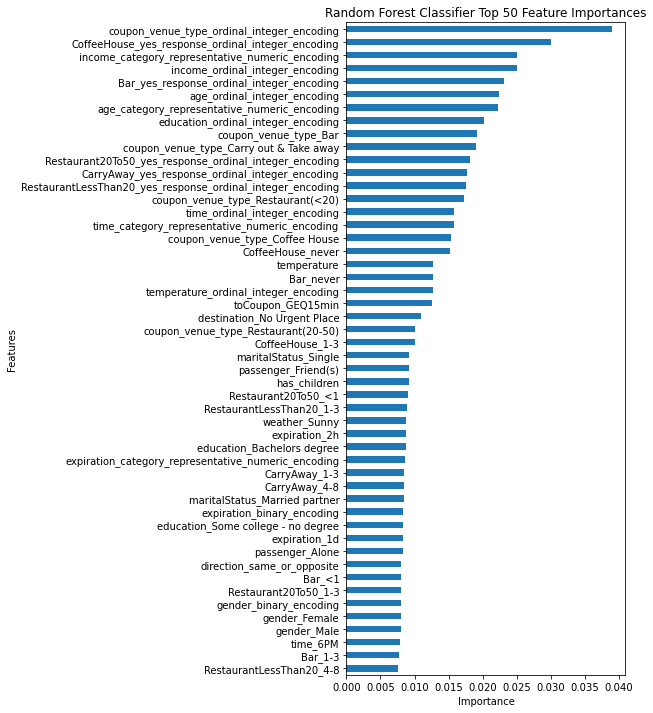

time: 2.41 s (started: 2022-10-15 12:04:30 -07:00)


In [42]:
#get feature importants plot

plt.subplots(figsize=(5, 12))

feature_importances = best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.feature_importances_
series_random_forest_classifier_feature_importances = pd.Series(feature_importances, 
                                                                 index=best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.X_columns).sort_values(ascending=False)
series_random_forest_classifier_feature_importances[0:50].sort_values(ascending=True).plot(kind='barh')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Random Forest Classifier Top 50 Feature Importances');

plt.savefig('../reports/figures/figure__random_forest_classifier_top_50_feature_importances_v' + filename_version + '.png', bbox_inches='tight', dpi=600)



In [43]:
column_name_list_random_forest_classifier_top_50_by_feature_importance = series_random_forest_classifier_feature_importances[0:50].index.to_list()

column_name_list_random_forest_classifier_top_25_by_feature_importance = series_random_forest_classifier_feature_importances[0:25].index.to_list()

pl(column_name_list_random_forest_classifier_top_50_by_feature_importance)

50


['coupon_venue_type_ordinal_integer_encoding',
 'CoffeeHouse_yes_response_ordinal_integer_encoding',
 'income_category_representative_numeric_encoding',
 'income_ordinal_integer_encoding',
 'Bar_yes_response_ordinal_integer_encoding',
 'age_ordinal_integer_encoding',
 'age_category_representative_numeric_encoding',
 'education_ordinal_integer_encoding',
 'coupon_venue_type_Bar',
 'coupon_venue_type_Carry out & Take away',
 'Restaurant20To50_yes_response_ordinal_integer_encoding',
 'CarryAway_yes_response_ordinal_integer_encoding',
 'RestaurantLessThan20_yes_response_ordinal_integer_encoding',
 'coupon_venue_type_Restaurant(<20)',
 'time_ordinal_integer_encoding',
 'time_category_representative_numeric_encoding',
 'coupon_venue_type_Coffee House',
 'CoffeeHouse_never',
 'temperature',
 'Bar_never',
 'temperature_ordinal_integer_encoding',
 'toCoupon_GEQ15min',
 'destination_No Urgent Place',
 'coupon_venue_type_Restaurant(20-50)',
 'CoffeeHouse_1-3',
 'maritalStatus_Single',
 'passenger

time: 2.08 ms (started: 2022-10-15 12:04:32 -07:00)


In [44]:
pl(column_name_list_random_forest_classifier_top_25_by_feature_importance)

25


['coupon_venue_type_ordinal_integer_encoding',
 'CoffeeHouse_yes_response_ordinal_integer_encoding',
 'income_category_representative_numeric_encoding',
 'income_ordinal_integer_encoding',
 'Bar_yes_response_ordinal_integer_encoding',
 'age_ordinal_integer_encoding',
 'age_category_representative_numeric_encoding',
 'education_ordinal_integer_encoding',
 'coupon_venue_type_Bar',
 'coupon_venue_type_Carry out & Take away',
 'Restaurant20To50_yes_response_ordinal_integer_encoding',
 'CarryAway_yes_response_ordinal_integer_encoding',
 'RestaurantLessThan20_yes_response_ordinal_integer_encoding',
 'coupon_venue_type_Restaurant(<20)',
 'time_ordinal_integer_encoding',
 'time_category_representative_numeric_encoding',
 'coupon_venue_type_Coffee House',
 'CoffeeHouse_never',
 'temperature',
 'Bar_never',
 'temperature_ordinal_integer_encoding',
 'toCoupon_GEQ15min',
 'destination_No Urgent Place',
 'coupon_venue_type_Restaurant(20-50)',
 'CoffeeHouse_1-3']

time: 1.27 ms (started: 2022-10-15 12:04:32 -07:00)


In [45]:

column_name_list_random_forest_classifier_top_50_by_feature_importance_target = column_name_list_random_forest_classifier_top_50_by_feature_importance + ['Y']
column_name_list_random_forest_classifier_top_25_by_feature_importance_target = column_name_list_random_forest_classifier_top_25_by_feature_importance + ['Y']
pl(column_name_list_random_forest_classifier_top_25_by_feature_importance_target)

26


['coupon_venue_type_ordinal_integer_encoding',
 'CoffeeHouse_yes_response_ordinal_integer_encoding',
 'income_category_representative_numeric_encoding',
 'income_ordinal_integer_encoding',
 'Bar_yes_response_ordinal_integer_encoding',
 'age_ordinal_integer_encoding',
 'age_category_representative_numeric_encoding',
 'education_ordinal_integer_encoding',
 'coupon_venue_type_Bar',
 'coupon_venue_type_Carry out & Take away',
 'Restaurant20To50_yes_response_ordinal_integer_encoding',
 'CarryAway_yes_response_ordinal_integer_encoding',
 'RestaurantLessThan20_yes_response_ordinal_integer_encoding',
 'coupon_venue_type_Restaurant(<20)',
 'time_ordinal_integer_encoding',
 'time_category_representative_numeric_encoding',
 'coupon_venue_type_Coffee House',
 'CoffeeHouse_never',
 'temperature',
 'Bar_never',
 'temperature_ordinal_integer_encoding',
 'toCoupon_GEQ15min',
 'destination_No Urgent Place',
 'coupon_venue_type_Restaurant(20-50)',
 'CoffeeHouse_1-3',
 'Y']

time: 1.64 ms (started: 2022-10-15 12:04:32 -07:00)


In [46]:
df_train = pd.concat([data_frame_collection['X_train'], data_frame_collection['y_train']], axis=1)
p(df_train)

(10147, 141)


,destination_Home,destination_No Urgent Place,destination_Work,passenger_Alone,passenger_Friend(s),passenger_Kid(s),passenger_Partner,weather_Rainy,weather_Snowy,weather_Sunny,time_10AM,time_10PM,time_2PM,time_6PM,time_7AM,coupon_venue_type_Bar,coupon_venue_type_Carry out & Take away,coupon_venue_type_Coffee House,coupon_venue_type_Restaurant(20-50),coupon_venue_type_Restaurant(<20),expiration_1d,expiration_2h,gender_Female,gender_Male,age_21-25,age_26-30,age_31-35,age_36-40,age_41-45,age_46-49,age_50+,age_<21,maritalStatus_Divorced,maritalStatus_Married partner,maritalStatus_Single,maritalStatus_Unmarried partner,maritalStatus_Widowed,education_Associates degree,education_Bachelors degree,education_Graduate degree (Masters or Doctorate),education_High School Graduate,education_Some High School,education_Some college - no degree,occupation_Architecture & Engineering,occupation_Arts Design Entertainment Sports & Media,occupation_Building & Grounds Cleaning & Maintenance,occupation_Business & Financial,occupation_Community & Social Services,occupation_Computer & Mathematical,occupation_Construction & Extraction,occupation_Education&Training&Library,occupation_Farming Fishing & Forestry,occupation_Food Preparation & Serving Related,occupation_Healthcare Practitioners & Technical,occupation_Healthcare Support,occupation_Installation Maintenance & Repair,occupation_Legal,occupation_Life Physical Social Science,occupation_Management,occupation_Office & Administrative Support,occupation_Personal Care & Service,occupation_Production Occupations,occupation_Protective Service,occupation_Retired,occupation_Sales & Related,occupation_Student,occupation_Transportation & Material Moving,occupation_Unemployed,income_$100000 or More,income_$12500 - $24999,income_$25000 - $37499,income_$37500 - $49999,income_$50000 - $62499,income_$62500 - $74999,income_$75000 - $87499,income_$87500 - $99999,income_Less than $12500,car_Car that is too old to install Onstar :D,car_Mazda5,car_Scooter and motorcycle,car_crossover,car_do not drive,car_no response,Bar_1-3,Bar_4-8,Bar_<1,Bar_>8,Bar_never,Bar_no response,CoffeeHouse_1-3,CoffeeHouse_4-8,CoffeeHouse_<1,CoffeeHouse_>8,CoffeeHouse_never,CoffeeHouse_no response,CarryAway_1-3,CarryAway_4-8,CarryAway_<1,CarryAway_>8,CarryAway_never,CarryAway_no response,RestaurantLessThan20_1-3,RestaurantLessThan20_4-8,RestaurantLessThan20_<1,RestaurantLessThan20_>8,RestaurantLessThan20_never,RestaurantLessThan20_no response,Restaurant20To50_1-3,Restaurant20To50_4-8,Restaurant20To50_<1,Restaurant20To50_>8,Restaurant20To50_never,Restaurant20To50_no response,temperature,has_children,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same_or_opposite,expiration_category_representative_numeric_encoding,time_category_representative_numeric_encoding,age_category_representative_numeric_encoding,income_category_representative_numeric_encoding,gender_binary_encoding,expiration_binary_encoding,coupon_venue_type_ordinal_integer_encoding,education_ordinal_integer_encoding,income_ordinal_integer_encoding,age_ordinal_integer_encoding,time_ordinal_integer_encoding,temperature_ordinal_integer_encoding,Bar_yes_response_ordinal_integer_encoding,CoffeeHouse_yes_response_ordinal_integer_encoding,CarryAway_yes_response_ordinal_integer_encoding,RestaurantLessThan20_yes_response_ordinal_integer_encoding,Restaurant20To50_yes_response_ordinal_integer_encoding,Bar_no_response_indicator,CoffeeHouse_no_response_indicator,CarryAway_no_response_indicator,RestaurantLessThan20_no_response_indicator,Restaurant20To50_no_response_indicator,Y
4946,1.708345,-0.990740,-0.576501,0.858105,-0.592768,-0.293504,-0.304303,-0.32474,-0.352942,0.509616,-0.467505,-0.433432,-0.433816,1.710829,-0.576501,-0.434842,-0.482217,-0.678192,2.738858,-0.530538,-1.125982,1.125982,-1.027012,1.027012,-0.514276,-0.502733,2.284884,-0.340673,-0.307079,-0.239115,-0.405089,-0.212294,-0.205928,-0.820042,1.291972,-0.456322,-0.101761,-0.316214,-0.720572,-0.413491,3.607696,-0.083584,-0.722593,-0.11

time: 61.9 ms (started: 2022-10-15 12:04:32 -07:00)


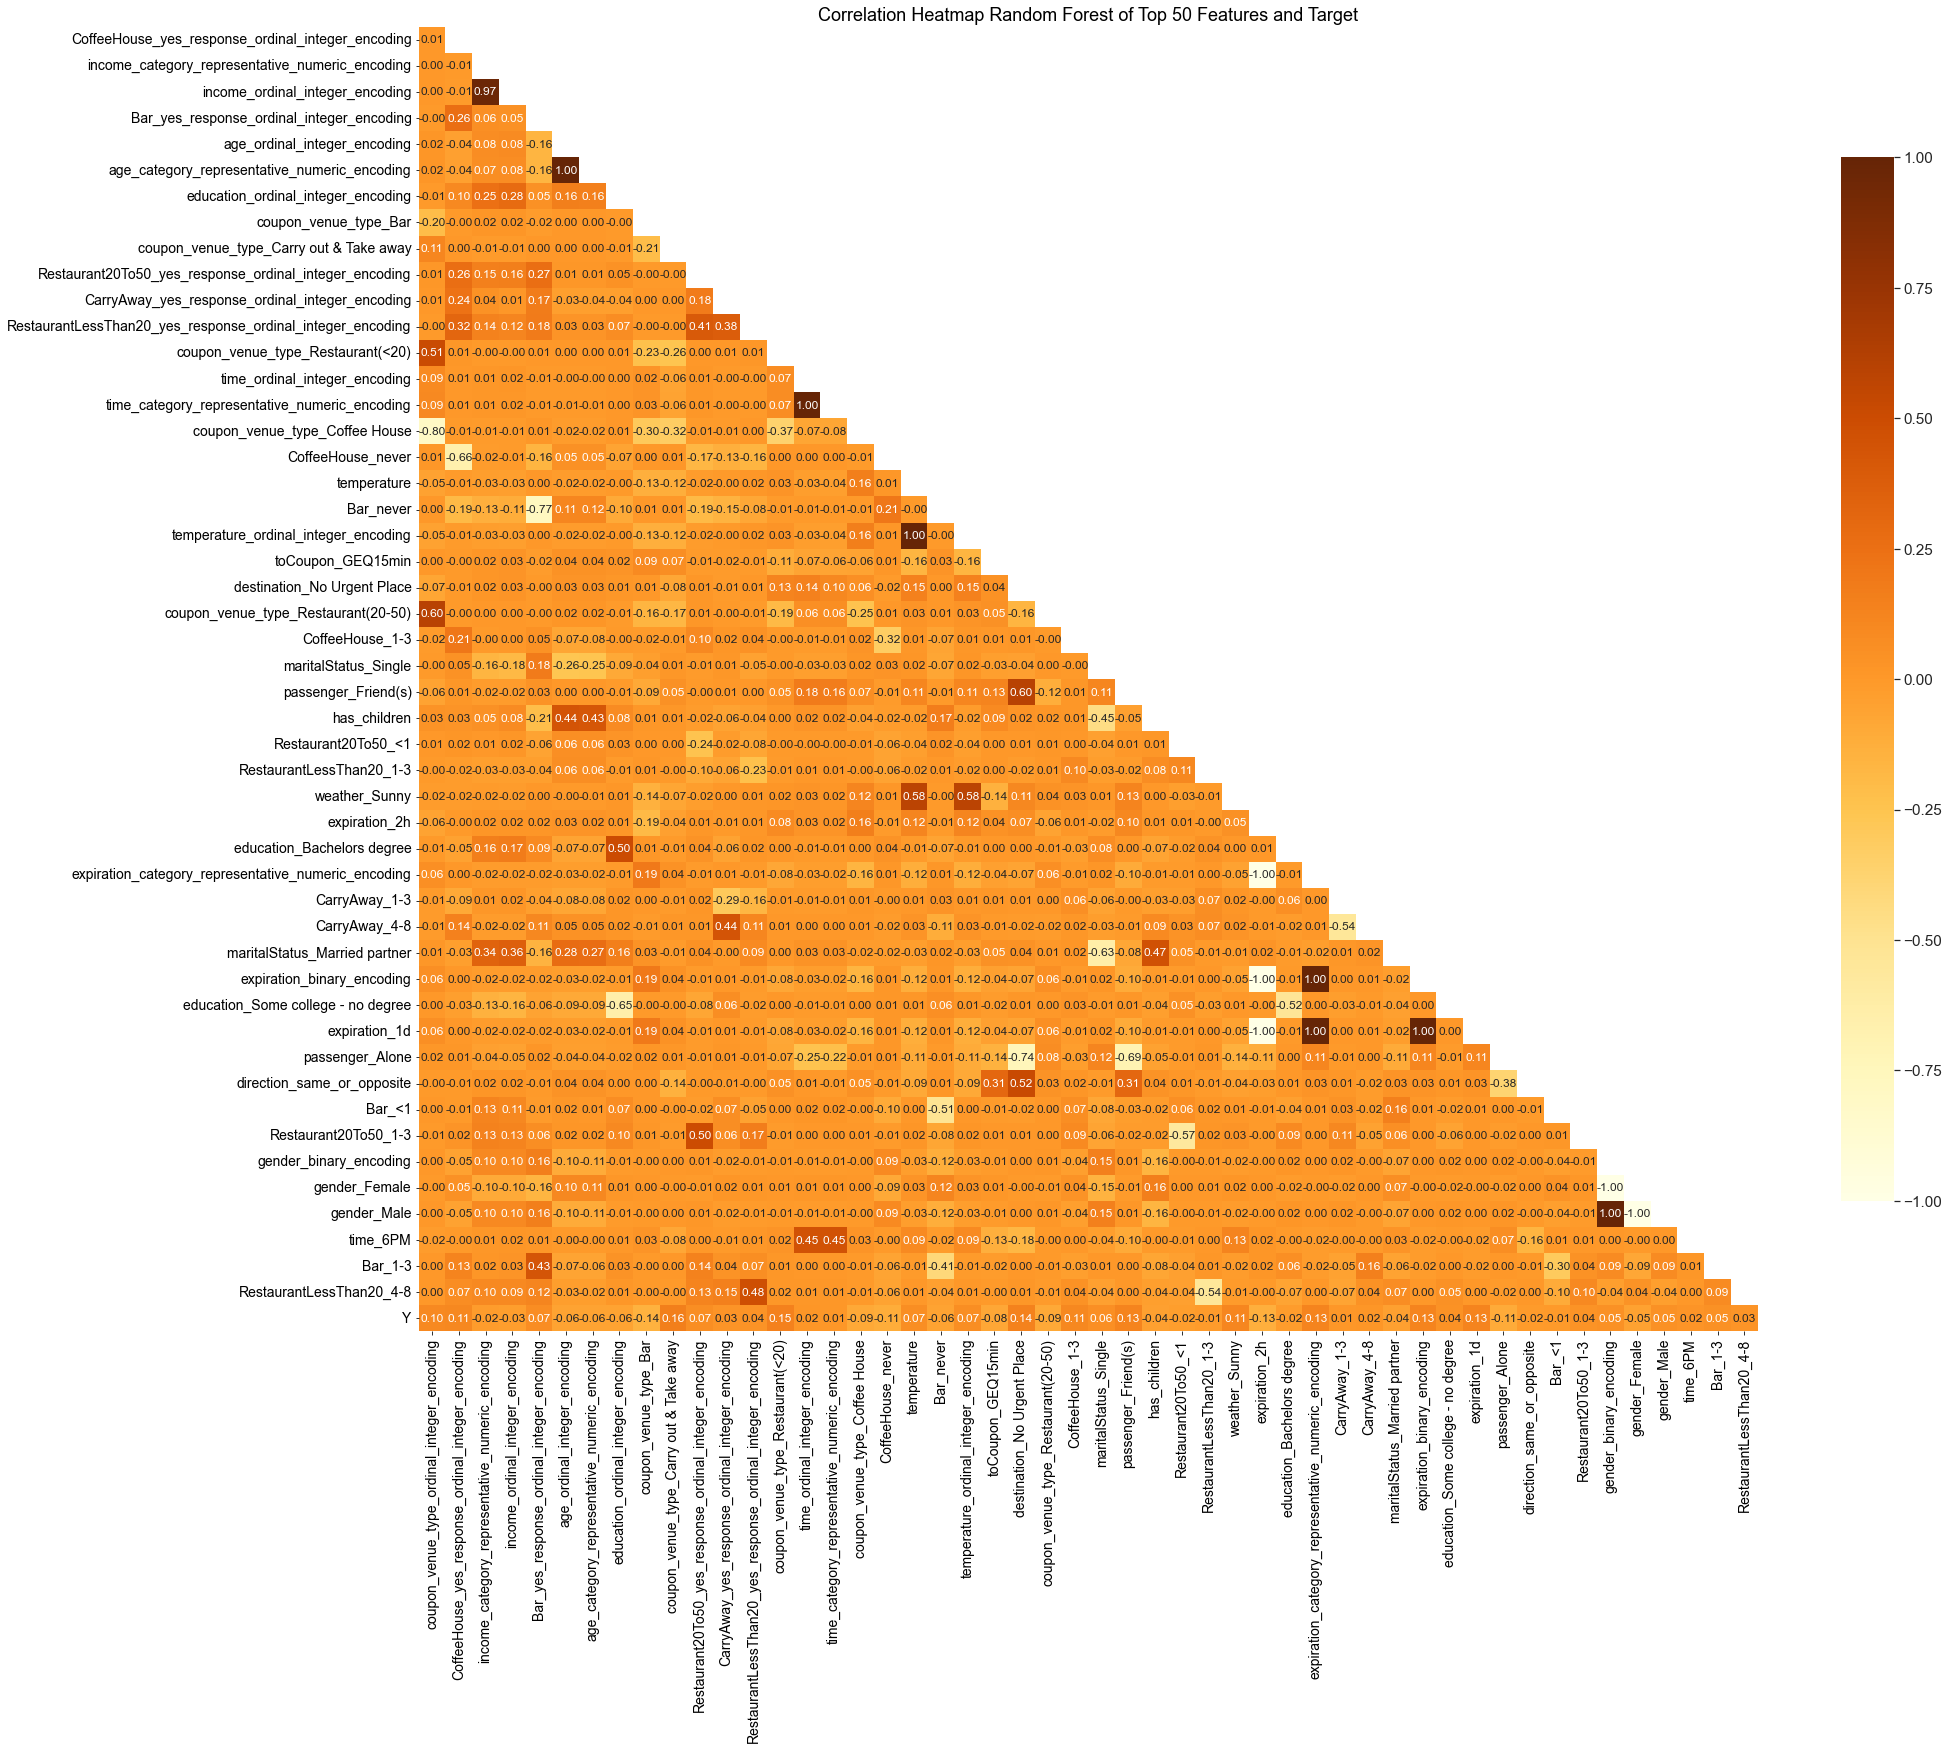

time: 16.2 s (started: 2022-10-15 12:04:32 -07:00)


In [47]:
#correlation heatmap of top 50 features and target

df_corr = df_train.loc[:, column_name_list_random_forest_classifier_top_50_by_feature_importance_target].corr() #correlation type??

fig, ax = plt.subplots(figsize=(30, 24))

mask = np.triu(np.ones_like(df_corr, dtype=bool))
mask = mask[1:, :-1]

corr = df_corr.iloc[1:,:-1].copy()

sns.set(font_scale=1.4)
sns.set_style("white")

res = sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", annot_kws={"size": 12}, cmap='YlOrBr', vmin=-1, vmax=1, cbar_kws={"shrink": .8})
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 14, rotation=90)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 14, rotation=0)

plt.title('Correlation Heatmap Random Forest of Top 50 Features and Target', fontsize=18)
plt.savefig('../reports/figures/figure_correlation_heatmap_random_forest_classifier_top_50_v' + filename_version + '.png', bbox_inches='tight', dpi=600)

plt.show()

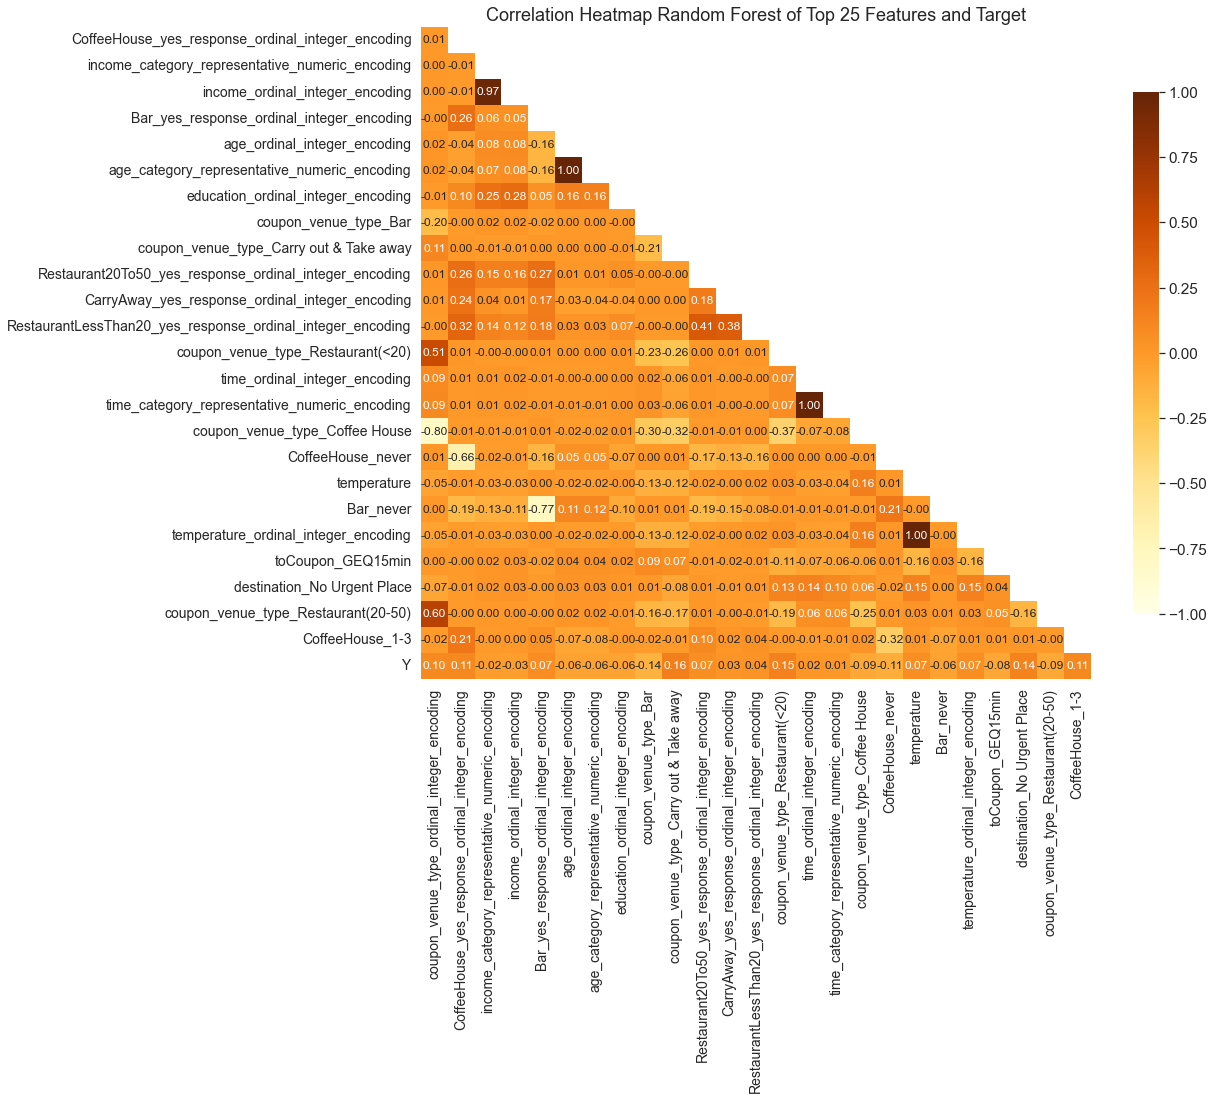

time: 5.69 s (started: 2022-10-15 12:04:48 -07:00)


In [48]:
#correlation heatmap of top 25 features and target

df_corr = df_train.loc[:, column_name_list_random_forest_classifier_top_25_by_feature_importance_target].corr() #correlation type??

fig, ax = plt.subplots(figsize=(15, 12))

mask = np.triu(np.ones_like(df_corr, dtype=bool))
mask = mask[1:, :-1]

corr = df_corr.iloc[1:,:-1].copy()

sns.set(font_scale=1.4)
sns.set_style("white")

res = sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", annot_kws={"size": 12}, cmap='YlOrBr', vmin=-1, vmax=1, cbar_kws={"shrink": .8})
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 14, rotation=90)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 14, rotation=0)

plt.title('Correlation Heatmap Random Forest of Top 25 Features and Target', fontsize=18)
plt.savefig('../reports/figures/figure_correlation_heatmap_random_forest_classifier_top_25_v' + filename_version + '.png', bbox_inches='tight', dpi=600)

plt.show()

In [49]:
#categories of top 25 features???

pl(column_name_list_random_forest_classifier_top_25_by_feature_importance)

#coupon_venue_type - coupon venue type

#temperature - outside temperature

#expiration - time til expiration

#CoffeeHouse - coffee house visits per month

25


['coupon_venue_type_ordinal_integer_encoding',
 'CoffeeHouse_yes_response_ordinal_integer_encoding',
 'income_category_representative_numeric_encoding',
 'income_ordinal_integer_encoding',
 'Bar_yes_response_ordinal_integer_encoding',
 'age_ordinal_integer_encoding',
 'age_category_representative_numeric_encoding',
 'education_ordinal_integer_encoding',
 'coupon_venue_type_Bar',
 'coupon_venue_type_Carry out & Take away',
 'Restaurant20To50_yes_response_ordinal_integer_encoding',
 'CarryAway_yes_response_ordinal_integer_encoding',
 'RestaurantLessThan20_yes_response_ordinal_integer_encoding',
 'coupon_venue_type_Restaurant(<20)',
 'time_ordinal_integer_encoding',
 'time_category_representative_numeric_encoding',
 'coupon_venue_type_Coffee House',
 'CoffeeHouse_never',
 'temperature',
 'Bar_never',
 'temperature_ordinal_integer_encoding',
 'toCoupon_GEQ15min',
 'destination_No Urgent Place',
 'coupon_venue_type_Restaurant(20-50)',
 'CoffeeHouse_1-3']

time: 1.58 ms (started: 2022-10-15 12:04:54 -07:00)


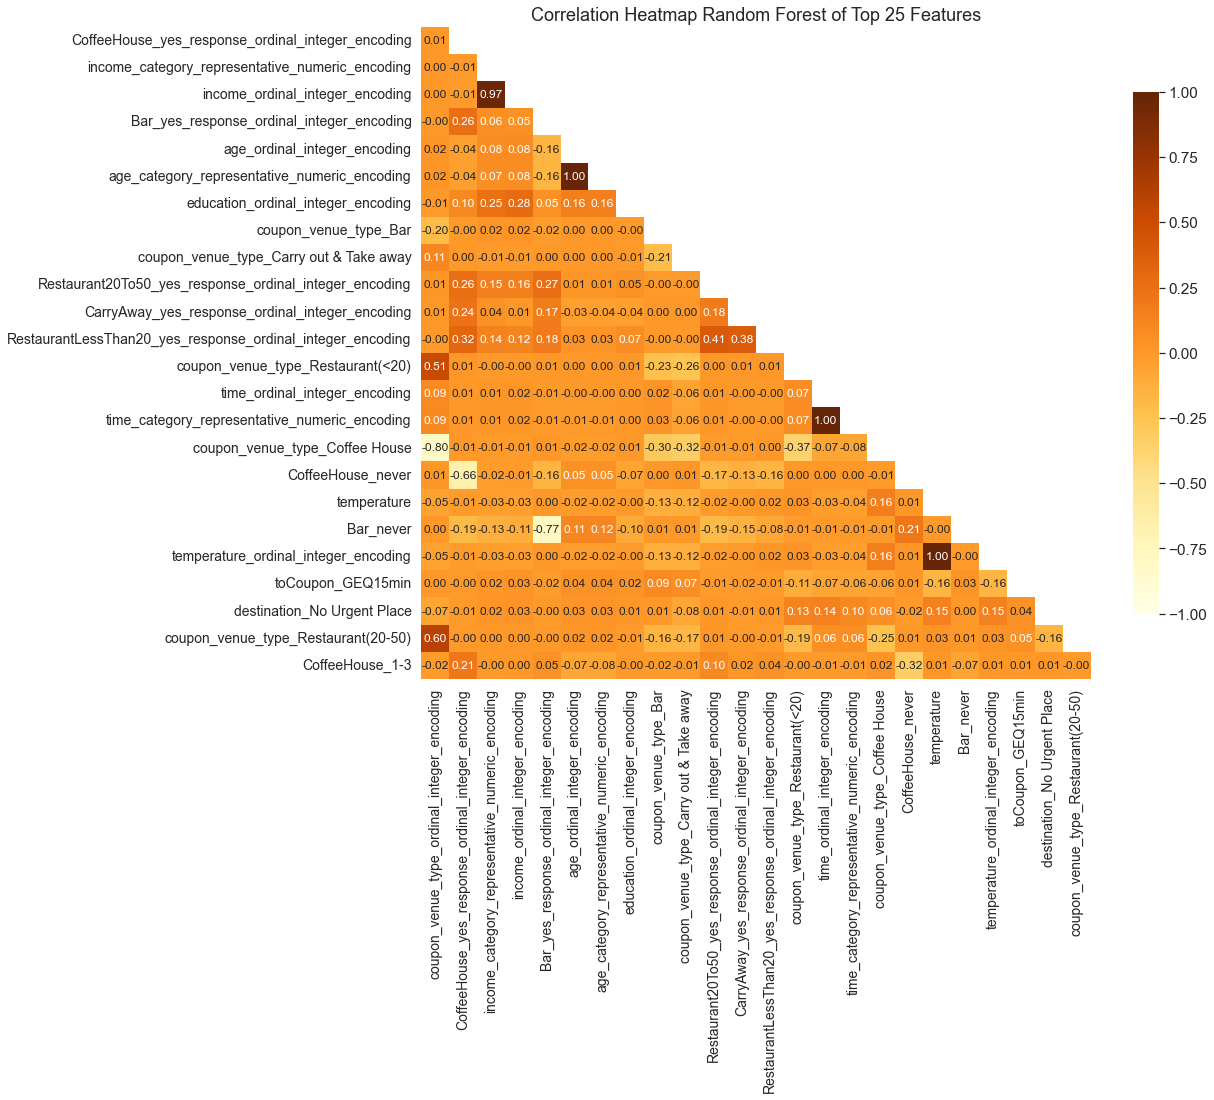

time: 5.47 s (started: 2022-10-15 12:04:54 -07:00)


In [50]:

#correlation heatmap of top features

df_corr = data_frame_collection['X_train'].loc[:, column_name_list_random_forest_classifier_top_25_by_feature_importance].corr()

fig, ax = plt.subplots(figsize=(15, 12))

mask = np.triu(np.ones_like(df_corr, dtype=bool))
mask = mask[1:, :-1]

corr = df_corr.iloc[1:,:-1].copy()

sns.set(font_scale=1.4)
sns.set_style("white")

res = sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", annot_kws={"size": 12}, cmap='YlOrBr', vmin=-1, vmax=1, cbar_kws={"shrink": .8})
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 14, rotation=90)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 14, rotation=0)

plt.title('Correlation Heatmap Random Forest of Top 25 Features', fontsize=18)
plt.savefig('../reports/figures/figure_correlation_heatmap_random_forest_classifier_top_25_v' + filename_version + '.png', bbox_inches='tight', dpi=600)

plt.show()

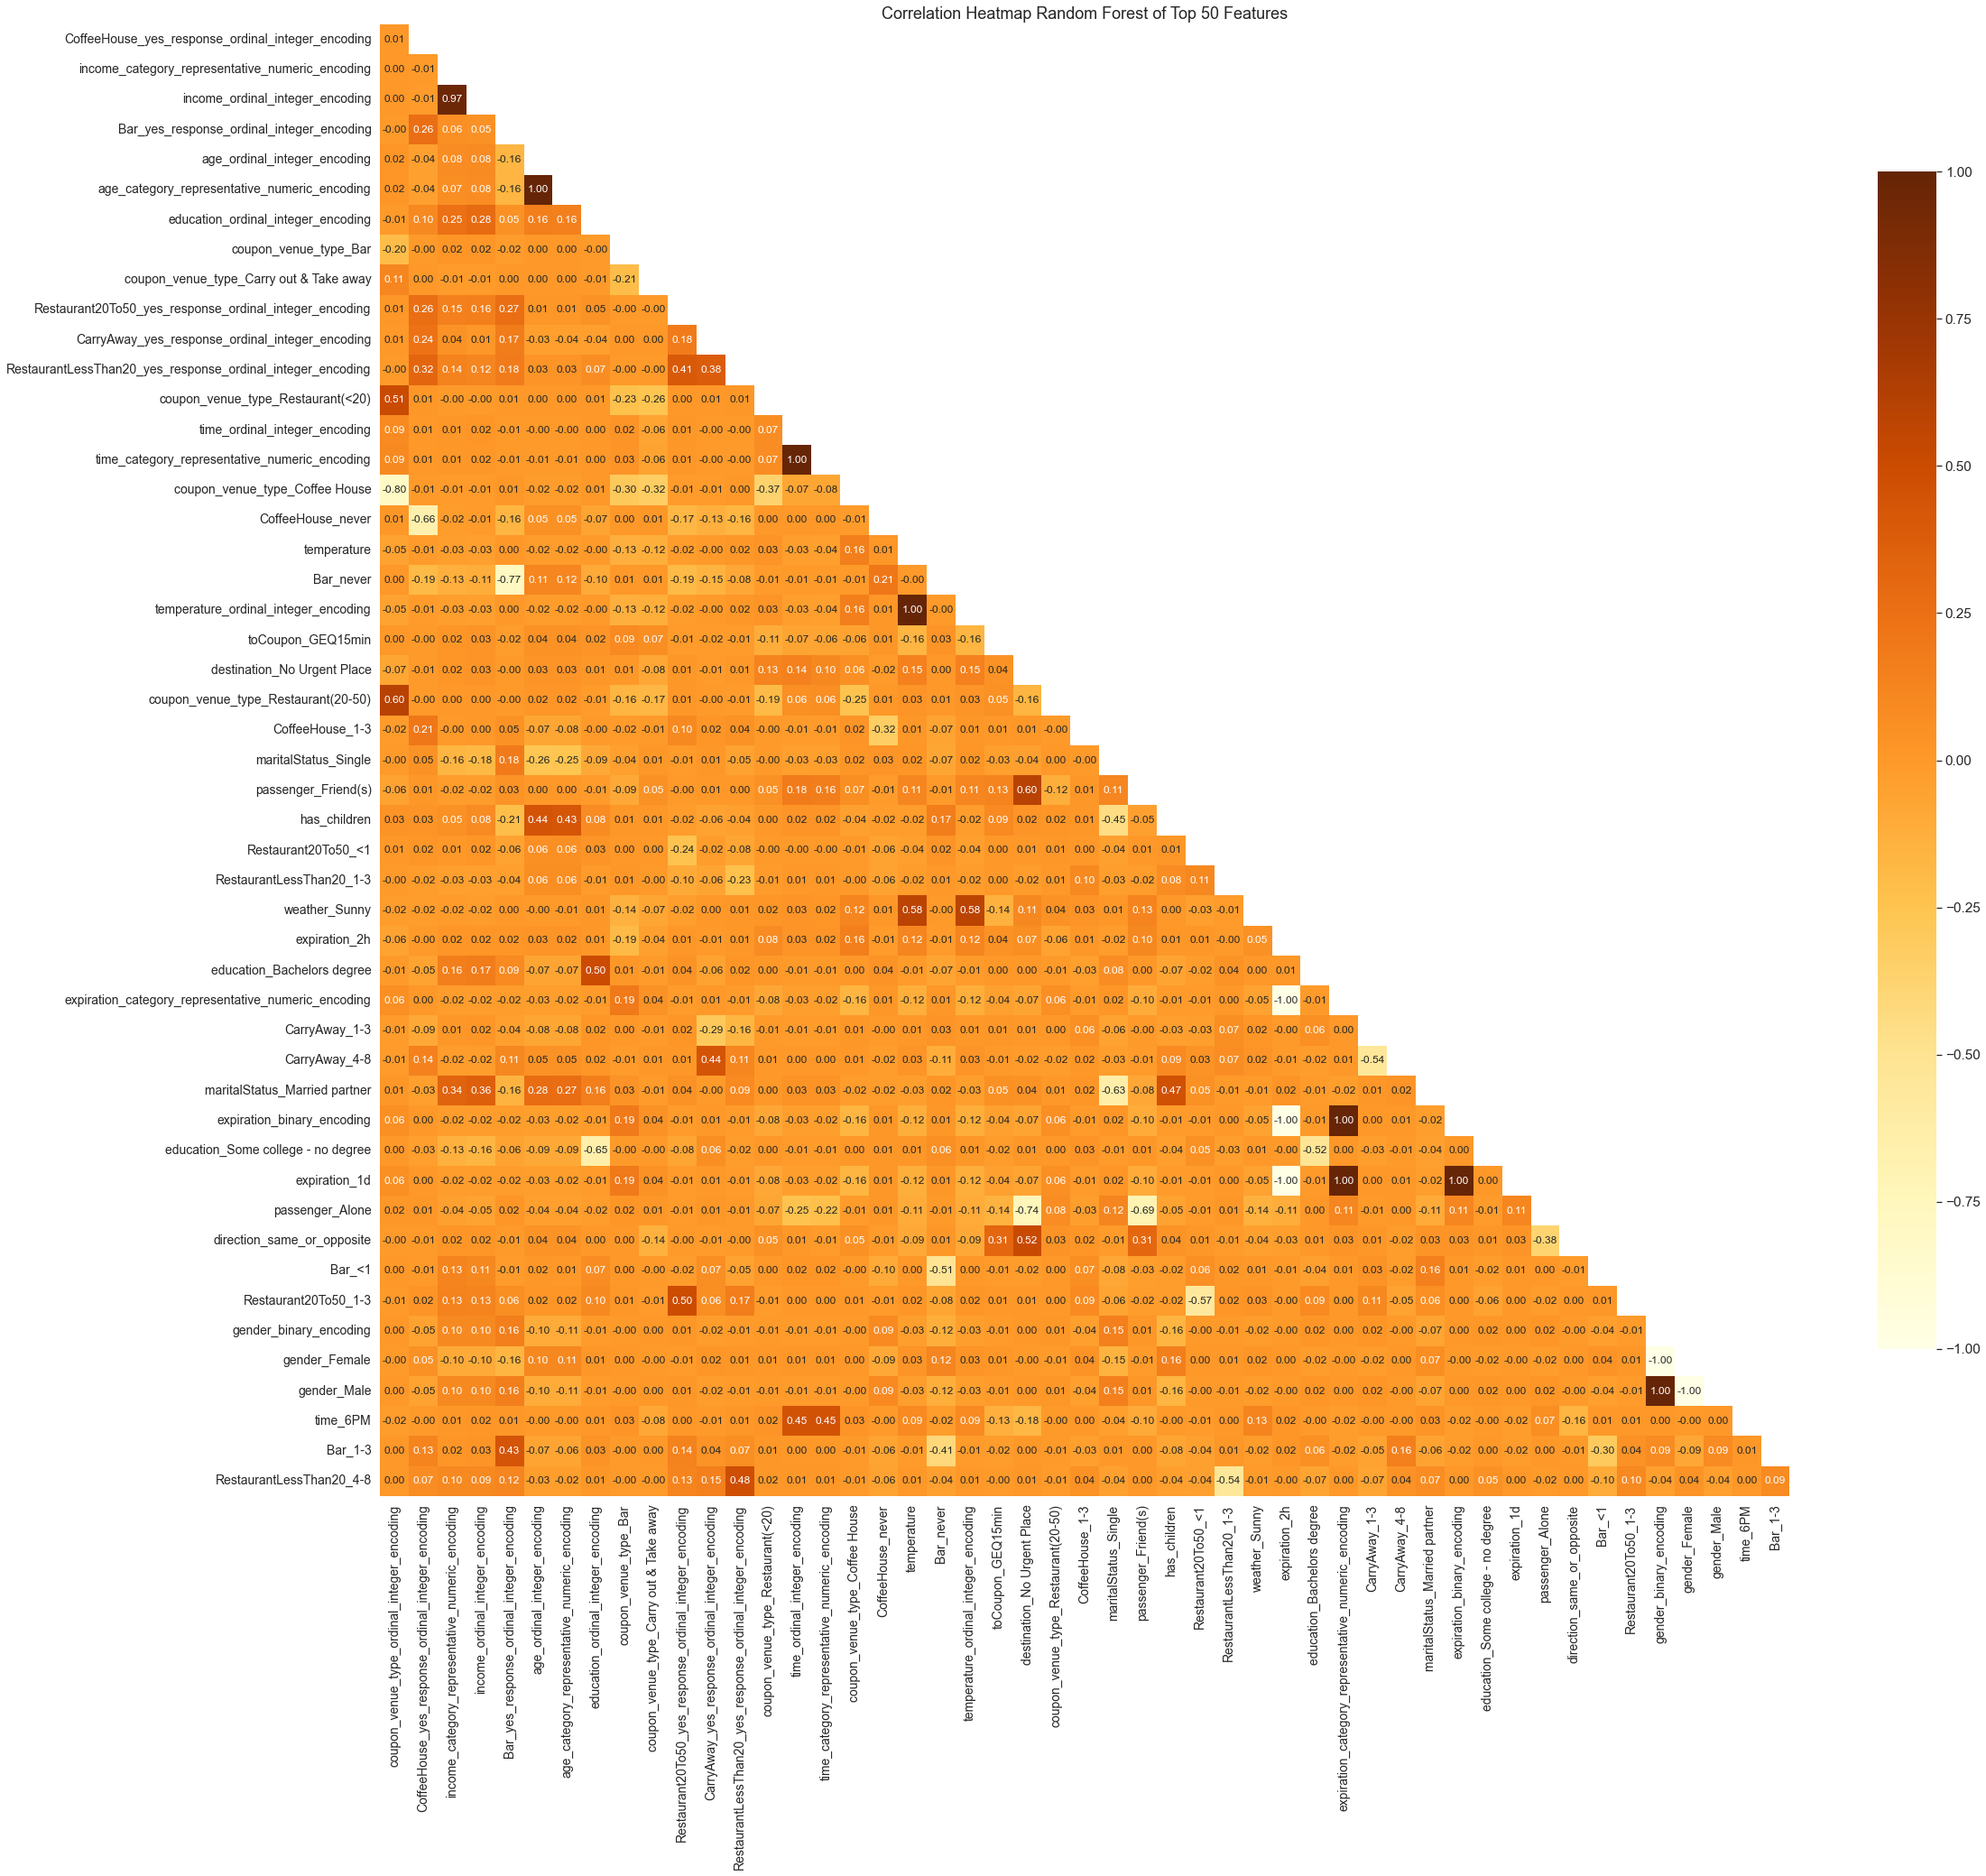

time: 18.6 s (started: 2022-10-15 12:04:59 -07:00)


In [51]:
#correlation heatmap of top features

df_corr = data_frame_collection['X_train'].loc[:, column_name_list_random_forest_classifier_top_50_by_feature_importance].corr()

fig, ax = plt.subplots(figsize=(35, 30))

mask = np.triu(np.ones_like(df_corr, dtype=bool))
mask = mask[1:, :-1]

corr = df_corr.iloc[1:,:-1].copy()

sns.set(font_scale=1.4)
sns.set_style("white")

res = sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", annot_kws={"size": 12}, cmap='YlOrBr', vmin=-1, vmax=1, cbar_kws={"shrink": .8})
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 14, rotation=90)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 14, rotation=0)

plt.title('Correlation Heatmap Random Forest of Top 50 Features', fontsize=18)
plt.savefig('../reports/figures/figure_correlation_heatmap_random_forest_classifier_top_50_v'+ filename_version +'.png', bbox_inches='tight', dpi=600)

plt.show()

In [52]:
# %%time
# #5-fold or whatever-fold cross validation

# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import cross_val_score

# random_forest_classifier = RandomForestClassifier(max_depth=10, min_samples_split=10, n_estimators=100, random_state=200)
# scores = cross_val_score(random_forest_classifier, X_train, y_train.loc[:, 'Y'], cv=5)
# print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

time: 511 µs (started: 2022-10-15 12:05:18 -07:00)


In [53]:
#stratified 5-fold cv????


time: 136 µs (started: 2022-10-15 12:05:18 -07:00)


In [54]:
#random forest hyperparameter tuning

time: 139 µs (started: 2022-10-15 12:05:18 -07:00)


In [55]:
#random forest classifier hyperparameters

#https://medium.com/analytics-vidhya/random-forest-classifier-and-its-hyperparameters-8467bec755f6

time: 165 µs (started: 2022-10-15 12:05:18 -07:00)


In [56]:
#results of random search????


time: 124 µs (started: 2022-10-15 12:05:18 -07:00)


In [57]:
#selecting number of base estimators, i.e. decision trees

#https://stats.stackexchange.com/questions/36165/does-the-optimal-number-of-trees-in-a-random-forest-depend-on-the-number-of-pred

time: 184 µs (started: 2022-10-15 12:05:18 -07:00)


In [58]:
#min_samples_split vs min_samples_leaf

#https://stackoverflow.com/questions/46480457/difference-between-min-samples-split-and-min-samples-leaf-in-sklearn-decisiontre

time: 194 µs (started: 2022-10-15 12:05:18 -07:00)


In [59]:
#how to show correlation for feature categories and boolean target variable???

#explain at the feature indicator level or the muli-category feature level???



time: 217 µs (started: 2022-10-15 12:05:18 -07:00)


In [60]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    accuracy = (predictions == test_labels.loc[:, 'Y']).value_counts('True')
    return accuracy

grid_accuracy = evaluate(best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier, data_frame_collection['X_train'], data_frame_collection['y_train'])
grid_accuracy

True     0.998423
False    0.001577
Name: Y, dtype: float64

time: 1.82 s (started: 2022-10-15 12:05:18 -07:00)


In [61]:
data_frame_collection['y_train_predicted'] = best_stratified_5_fold_grid_search_cross_validation_random_forest_classifier.predict(data_frame_collection['X_train'])

(data_frame_collection['y_train_predicted'] == data_frame_collection['y_train'].loc[:, 'Y']).value_counts('True')

True     0.998423
False    0.001577
Name: Y, dtype: float64

time: 1.53 s (started: 2022-10-15 12:05:20 -07:00)


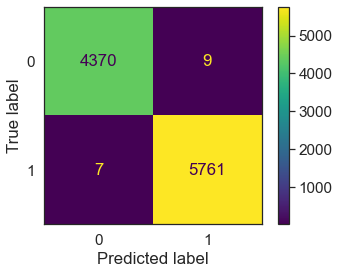

time: 80 ms (started: 2022-10-15 12:05:22 -07:00)


In [62]:
confusion_matrix = metrics.confusion_matrix(data_frame_collection['y_train'], data_frame_collection['y_train_predicted'])

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()

In [63]:
confusion_matrix

array([[4370,    9],
       [   7, 5761]])

time: 1.63 ms (started: 2022-10-15 12:05:22 -07:00)


In [64]:
df_train.shape[0]

10147

time: 1.23 ms (started: 2022-10-15 12:05:22 -07:00)


In [65]:
np.round(confusion_matrix/df_train.shape[0]*100, 2)

array([[43.07,  0.09],
       [ 0.07, 56.78]])

time: 1.93 ms (started: 2022-10-15 12:05:22 -07:00)


In [66]:
#AUC ROC

time: 164 µs (started: 2022-10-15 12:05:22 -07:00)


In [67]:
#plain english

#https://python.plainenglish.io/roc-auc-in-machine-learning-d70d4308f636

time: 204 µs (started: 2022-10-15 12:05:22 -07:00)


Accuracy for Random Forest Classifier : 0.9649122807017544
Accuracy for Logistic Regression : 0.9649122807017544
Accuracy for Naive Bayes : 0.9473684210526315


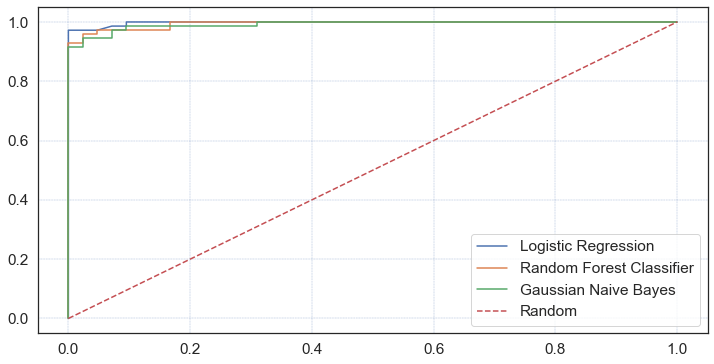

time: 518 ms (started: 2022-10-15 12:05:22 -07:00)


In [68]:
#get dataset
from sklearn.datasets import load_breast_cancer
breast_cancer=load_breast_cancer()
X=breast_cancer.data
y=breast_cancer.target

from sklearn.model_selection import train_test_split
import numpy as np

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=101)


#ML
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

model1=RandomForestClassifier(max_features=3)
model1.fit(X_train,y_train)
y1_pred=model1.predict(X_test)

model2=LogisticRegression(max_iter=3000)
model2.fit(X_train,y_train)
y2_pred=model2.predict(X_test)

model3=GaussianNB()
model3.fit(X_train,y_train)
y3_pred=model3.predict(X_test)

#get ML metrics
from sklearn import metrics
models=['Random Forest Classifier','Logistic Regression','Naive Bayes']
accuracy=[y1_pred,y2_pred,y3_pred]

for i,j in zip(models,accuracy):
  print("Accuracy for {} : {}".format(i,metrics.accuracy_score(y_test,j)))


#calculate probability metrics
r_probs=[0 for i in range(len(y_test))]
y1_pred_proba=model1.predict_proba(X_test)[::,1]
y2_pred_proba=model2.predict_proba(X_test)[::,1]
y3_pred_proba=model3.predict_proba(X_test)[::,1]


#calculate fpr, tpr, and threshold metrics
fpr1, tpr1, _a = metrics.roc_curve(y_test,  y1_pred_proba)
fpr2,tpr2,_b= metrics.roc_curve(y_test,  y2_pred_proba)
fpr3,tpr3,_c= metrics.roc_curve(y_test,  y3_pred_proba)
fpr4,tpr4,_d= metrics.roc_curve(y_test,  r_probs)


#plot metrics
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(fpr1,tpr1,label="Logistic Regression")
plt.plot(fpr2,tpr2,label="Random Forest Classifier")
plt.plot(fpr3,tpr3,label="Gaussian Naive Bayes")
plt.plot(fpr4,tpr4,'--',label="Random")

plt.legend(loc=4)
plt.grid(color='b', ls = '-.', lw = 0.25)
plt.show()

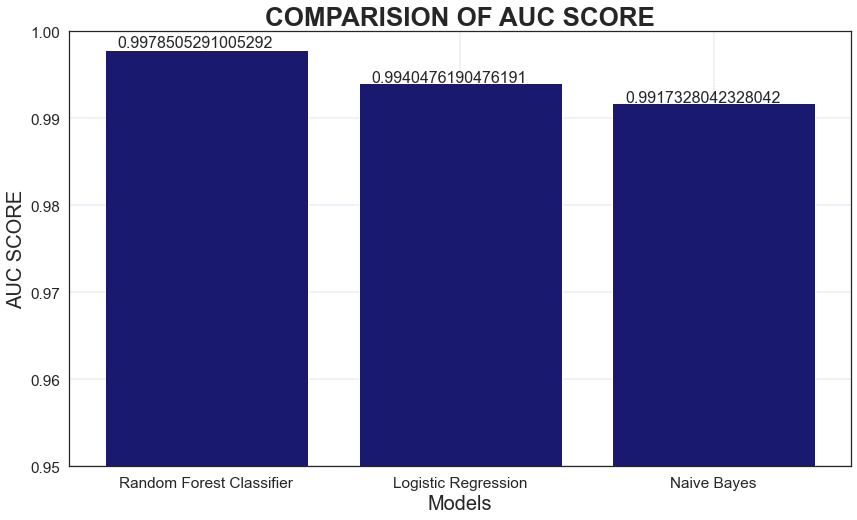

time: 87.7 ms (started: 2022-10-15 12:05:22 -07:00)


In [69]:
#calculate auc_score metric
auc_score=[metrics.roc_auc_score(y_test,i) for i in [y1_pred_proba,y2_pred_proba,y3_pred_proba] ]

#plot auc score metric
plt.figure(figsize=(14,8))
plt.bar(models,auc_score,color='midnightblue',width=0.8)
plt.xlabel('Models',fontsize=20)
plt.ylabel('AUC SCORE',fontsize=20)
plt.title('COMPARISION OF AUC SCORE',fontsize=26,weight='bold')
plt.ylim(top=1)
plt.ylim(bottom=0.95)
plt.grid(color='b',ls='-.',lw=0.25)

#for displaying the value above plot
plt.text(-.35,0.9982,str(auc_score[0]),fontsize=16)
plt.text(0.65,0.9942,str(auc_score[1]),fontsize=16)
plt.text(1.65,0.9919,str(auc_score[2]),fontsize=16)
plt.show()

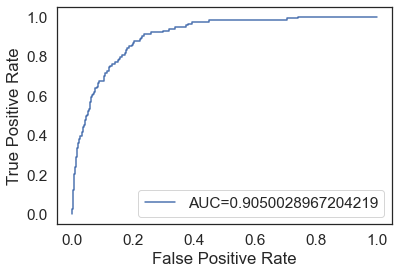

time: 519 ms (started: 2022-10-15 12:05:22 -07:00)


In [70]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt

#import dataset from CSV file on Github
url = "https://raw.githubusercontent.com/Statology/Python-Guides/main/default.csv"
data = pd.read_csv(url)

#define the predictor variables and the response variable
X = data[['student', 'balance', 'income']]
y = data['default']

#split the dataset into training (70%) and testing (30%) sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0) 

#instantiate the model
log_regression = LogisticRegression()

#fit the model using the training data
log_regression.fit(X_train,y_train)



#define metrics
y_pred_proba = log_regression.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [71]:
# import pandas as pd
# import seaborn as sn
# import matplotlib.pyplot as plt


# confusion_matrix = pd.crosstab(y_train.loc[:, 'Y'], df_target_predicted, rownames=['Actual'], colnames=['Predicted'], margins = True)

# sn.heatmap(confusion_matrix, annot=True)
# plt.show()

# #fix to standard form instead of scientific notation???

time: 305 µs (started: 2022-10-15 12:05:23 -07:00)


<font size="5"><a id='[Results]'></a> </font> <font>Table of Contents</font> <font size="2">[Data Wrangling](#[Data_Wrangling])</font> <font size="2">[Feature Engineering](#[Feature_Engineering])</font> <font size="2">[Exploratory Data Analysis](#[Exploratory_Data_Analysis])</font> <font size="2">[Data Preprocessing](#[Data_Preprocessing])</font> <font size="2">[Modeling](#[Modeling])</font> <font size="2">[Results](#[Results])</font>

<font size="6"><a id='[Results]'>**Results**</a> </font>

In [72]:
# grid_accuracy = evaluate(best_grid_cross_validation_random_forest_classifier, X_test, y_test.loc[:, 'Y'])
# grid_accuracy

time: 268 µs (started: 2022-10-15 12:05:23 -07:00)


In [73]:
# !conda install wordcloud

time: 164 µs (started: 2022-10-15 12:05:23 -07:00)


In [74]:
# !pip install autoviz

time: 162 µs (started: 2022-10-15 12:05:23 -07:00)


In [75]:
# from autoviz.AutoViz_Class import AutoViz_Class
# AV = AutoViz_Class()
# help(AV.AutoViz)

time: 212 µs (started: 2022-10-15 12:05:23 -07:00)


In [76]:
# df = AV.AutoViz(os.path.join('..', 'data', 'raw', 'fraudTrain.csv'))

time: 191 µs (started: 2022-10-15 12:05:23 -07:00)


In [77]:
# df = AV.AutoViz(os.path.join('..', 'data', 'raw', 'fraudTest.csv'))

time: 179 µs (started: 2022-10-15 12:05:23 -07:00)
